# Notebook for Result Visualization

This notebook is used to generate all the figures that summarize \
the results of the data
partition analysis. It is divided in three main subsections:

1. Intra-subject vs Inter-subject variability
2. LNSO vs N-LNSO
3. LOSO vs Full N-LOSO


## Import packages

In [7]:
import glob
import os
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
import matplotlib.gridspec as gridspec
from scipy import stats
import seaborn as sns
import math
from AllFnc.utilities import (
    GetLearningRateString,
    get_full_name,
    gather_metric_values,
    convert_performance_totable
)

import warnings 
warnings.filterwarnings("ignore", category = FutureWarning)

In [8]:
style = "light"

custom_params_dark = {
    'figure.facecolor': 'white',
    'axes.labelcolor': '.15',
    'xtick.direction': 'out',
    'ytick.direction': 'out',
    'xtick.color': '.15',
    'ytick.color': '.15',
    'axes.axisbelow': True,
    'grid.linestyle': '-',
    'text.color': '.15',
    'font.family': ['sans-serif'],
    'font.sans-serif': ['Arial',
    'DejaVu Sans',
    'Liberation Sans',
    'Bitstream Vera Sans',
    'sans-serif'],
    'lines.solid_capstyle': 'round',
    'patch.edgecolor': 'w',
    'patch.force_edgecolor': True,
    'image.cmap': 'rocket',
    'xtick.top': False,
    'ytick.right': False,
    'axes.grid': True,
    'axes.facecolor': '#EAEAF2',
    'axes.edgecolor': '#0072b2',
    'grid.color': 'white',
    'axes.spines.left': True,
    'axes.spines.bottom': True,
    'axes.spines.right': True,
    'axes.spines.top': True,
    'xtick.bottom': False,
    'ytick.left': False
}
custom_params_light = {
    "axes.spines.right": False,
    "axes.spines.top": False,
    'axes.grid': True,
    'grid.linestyle': '-',
    #'grid.color': '#d1dce6',
    'grid.color': 'lightgray',
}
if style == "dark":
    folder = "DarkTheme"
    sns.set_style("darkgrid", rc = custom_params_dark)
elif style == "light":
    folder = "LightTheme"
    sns.set_theme(style="ticks", rc=custom_params_light)
sns.set_context("paper", font_scale=1.5)  

## Intra-subject (KFOLD) vs Inter-subject (LNSO)

In [4]:
metric = 'accuracy_weighted'
task = ['pds', 'alz', 'bci']
model = ['shn', 'dcn', 'res']
partition = ['KFOLD', 'LNSO']

performances    = gather_metric_values(metric, task, model, partition)
performances_df = convert_performance_totable(performances)

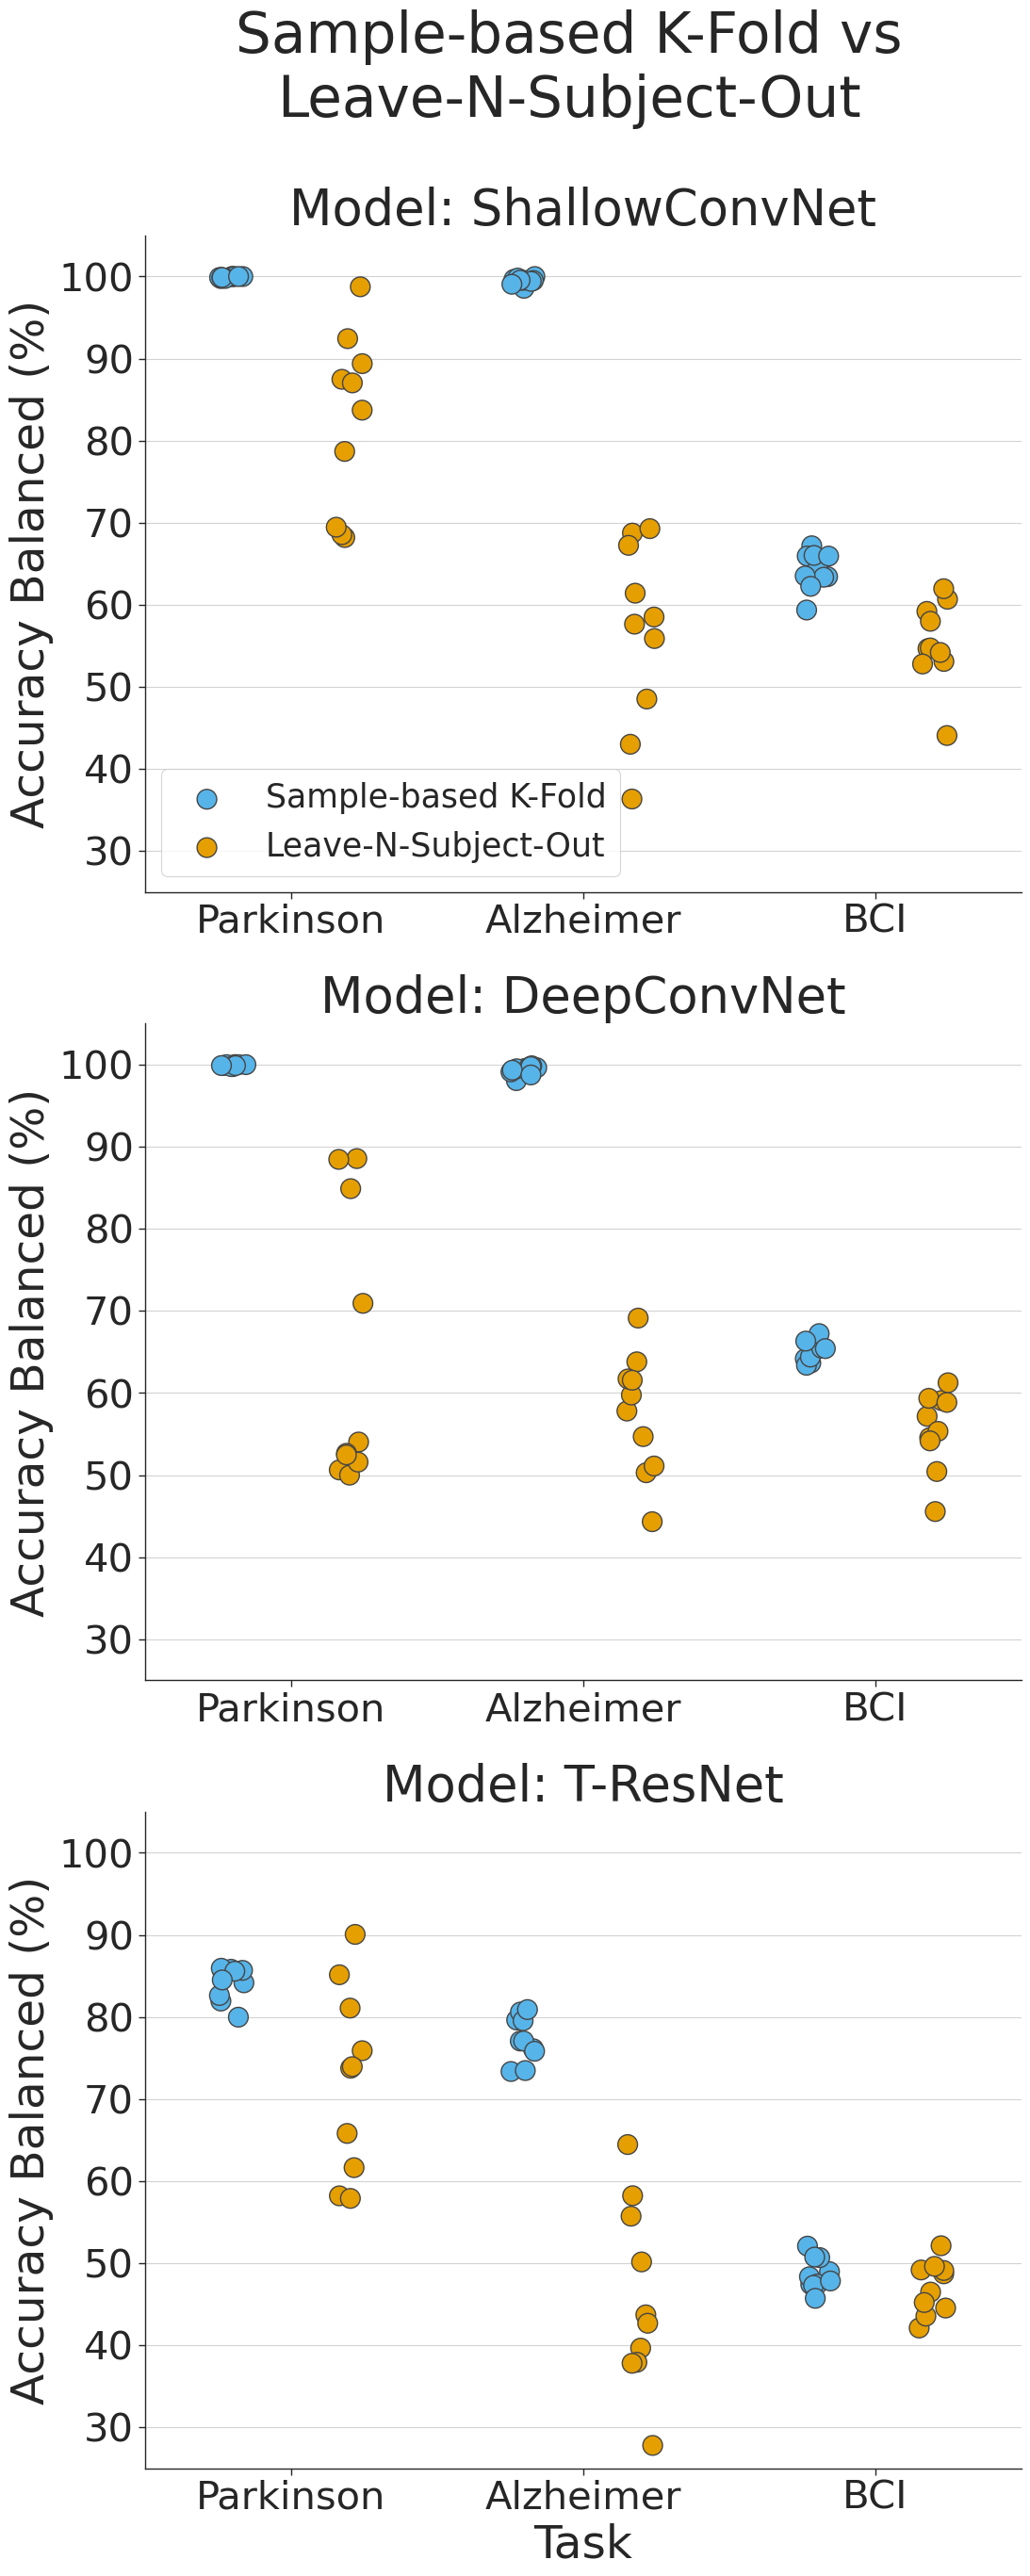

In [5]:
font = 35
fig, ax = plt.subplots(3, 1, figsize=(12, 30))
for n, i in enumerate(model):
    model_df = performances_df.loc[performances_df["Model"]==i]
    model_df.loc[:,"Task"] = model_df.loc[:,"Task"].apply(get_full_name)
    if i == 'shn':
        model_shn = model_df.copy()
    sns.stripplot(
        x         = 'Task',
        y         = 'Metric',
        data      = model_df,
        legend    = False,
        linewidth = 1,
        hue       = 'Partition',
        dodge     = True,
        ax        = ax[n],
        size      = 15,
        palette   = ["#56b4e9", "#e69f00"]
    )
    #ax[n].set_yticks([i*5 for i in range(5, 21)])
    ax[n].set_yticks([i*10 for i in range(2, 11)])
    ax[n].set_title( f'Model: {get_full_name(i)}',fontsize = font+3)
    if n == 2:
        ax[n].set_xlabel('Task', fontsize = font)
    else:
        ax[n].set(xlabel=None)
        if n==0:
            ax[n].legend(
                ["Sample-based K-Fold", "Leave-N-Subject-Out"],
                fontsize = font-10,
                loc = "lower left"
            )
    ax[n].set_ylabel('Accuracy Balanced (%)', fontsize = font)
    ax[n].set_ylim(25,105)
    ax[n].tick_params(axis='both', which='major', labelsize=font-5)
fig.suptitle( f'Sample-based K-Fold vs\nLeave-N-Subject-Out',fontsize = font+8)
plt.subplots_adjust(top=0.9)
#plt.savefig(f"Images/{folder}/Kfold_vs_LNSO_concat_vertical.pdf")
plt.show()

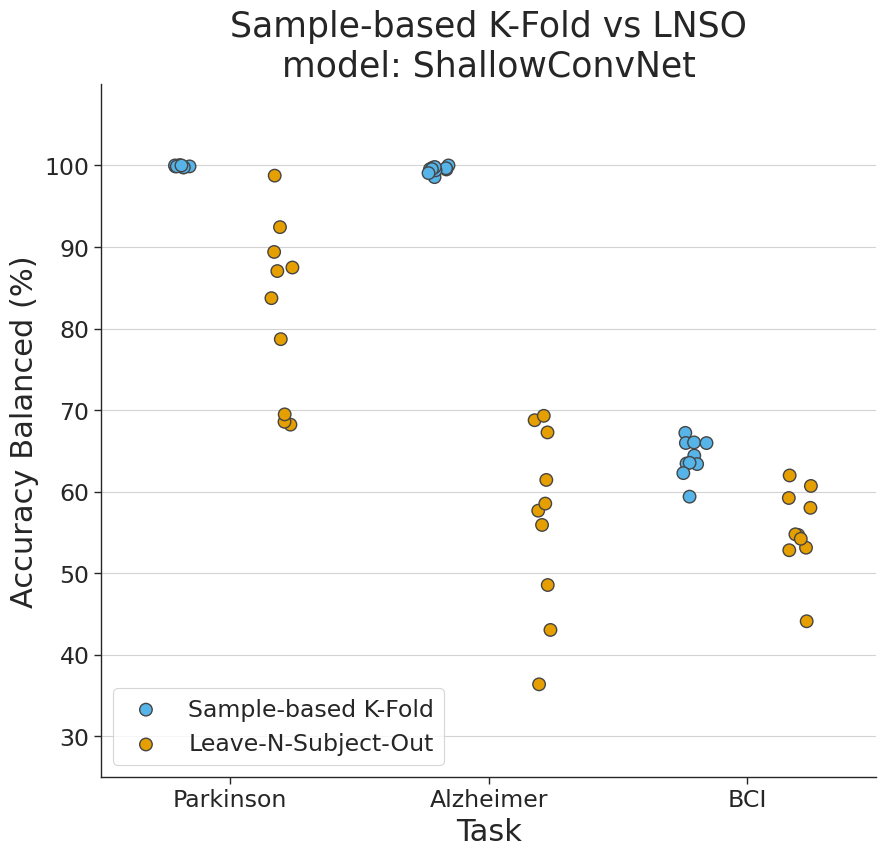

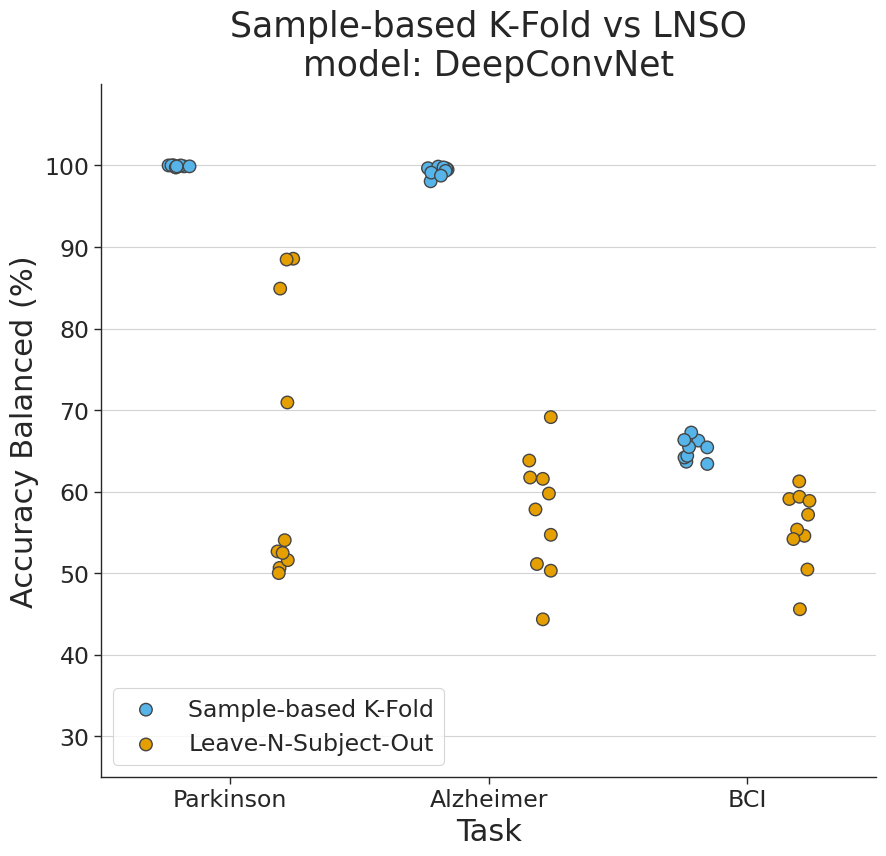

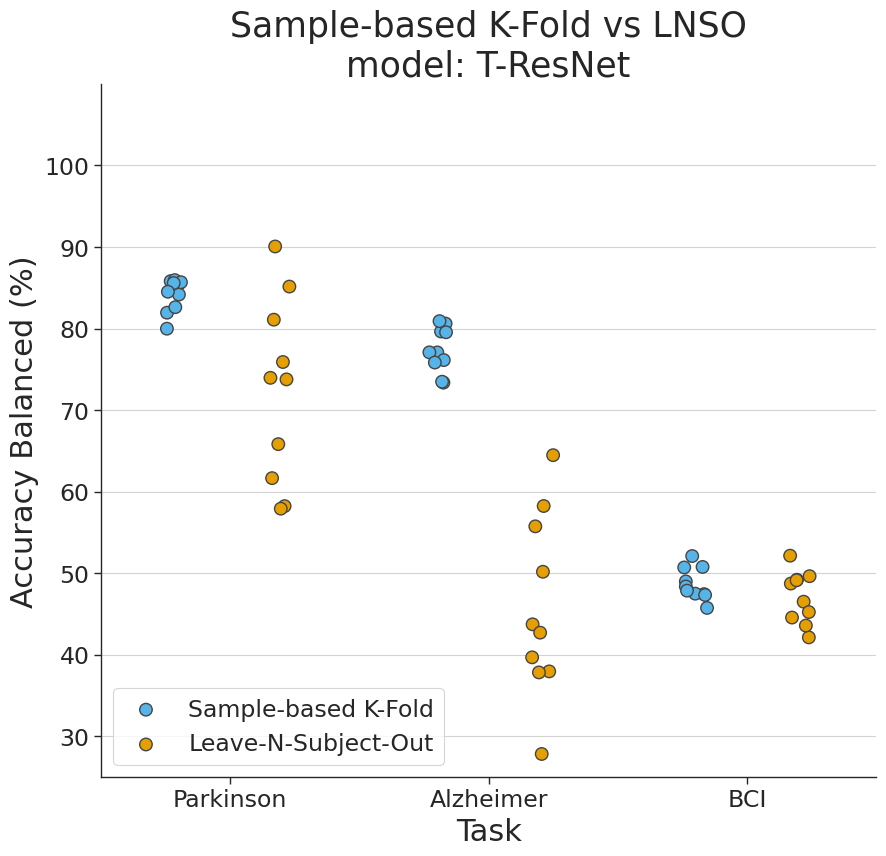

In [6]:
font = 22
for i in model:
    model_df = performances_df.loc[performances_df["Model"]==i]
    model_df.loc[:,"Task"] = model_df.loc[:,"Task"].apply(get_full_name)
    fig, ax = plt.subplots(figsize=(10, 9))
    #sns.boxplot(x='Task', y='Metric', hue='Partition', data=model_df, showfliers=False, ax=ax)
    sns.stripplot(
        x         = 'Task',
        y         = 'Metric',
        data      = model_df,
        legend    = False,
        linewidth = 1,
        hue       = 'Partition',
        dodge     = True,
        ax        = ax,
        size      = 9,
        palette   = ["#56b4e9", "#e69f00"]
    )
    #ax.set_yticks([i*5 for i in range(5, 21)])
    ax.set_yticks([i*10 for i in range(2, 11)])
    ax.set_title( f'Sample-based K-Fold vs LNSO\nmodel: {get_full_name(i)}',fontsize = font+3)
    ax.set_xlabel('Task', fontsize = font)
    ax.set_ylabel('Accuracy Balanced (%)', fontsize = font)
    ax.set_ylim(5*5,110)
    ax.tick_params(axis='both', which='major', labelsize=font-5)
    plt.legend(["Sample-based K-Fold", "Leave-N-Subject-Out"], fontsize = font-5, loc = "lower left")
    plt.savefig(f"Images/{folder}/Kfold_vs_LNSO_model_{get_full_name(i)}.pdf")
    plt.show()

## Quantitative analysis using additional nested level

Comparing the results of subject-based and sample-based cross-validation methods
is not possible. Groups have folds that are not completely independent
(there is a 10% overlap), nor they can be considered paired. Both the Wilcoxon signed-rank 
or the Mann Whiteny U cannot be used in this context. Additionally, any statistical test
will tell if a mode

In [7]:
metric = 'accuracy_weighted'
task = ['pds', 'alz', 'bci']
model = ['shn', 'dcn', 'res']
partition = ['NKFOLD','NLNSO']

performances, performances_val = gather_metric_values(metric, task, model, partition, True)
performances_df = convert_performance_totable(performances, performances_val)

In [8]:
grouped = performances_df.groupby(["Partition", "Task", "Model", "Outer"])
#df2 = grouped.apply(lambda x: x.Metric[x.MetricVal.idxmax()], include_groups=False)
df2 = grouped.apply(lambda x: x.Metric.mean(), include_groups=False)
df2 = df2.reset_index().rename(columns={0: "Metric"})
df3 = grouped.apply(lambda x: x.MetricVal.mean(), include_groups=False)
df3 = df3.reset_index().rename(columns={0: "Metric"})
df2["MetricDiff"] = df3["Metric"]- df2["Metric"]

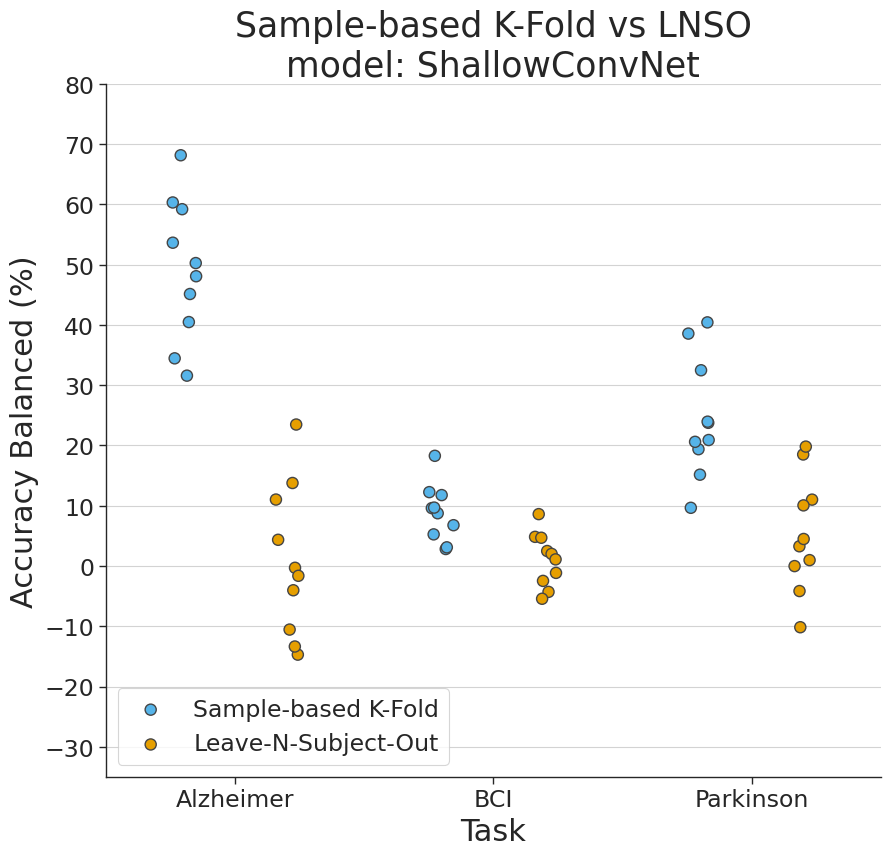

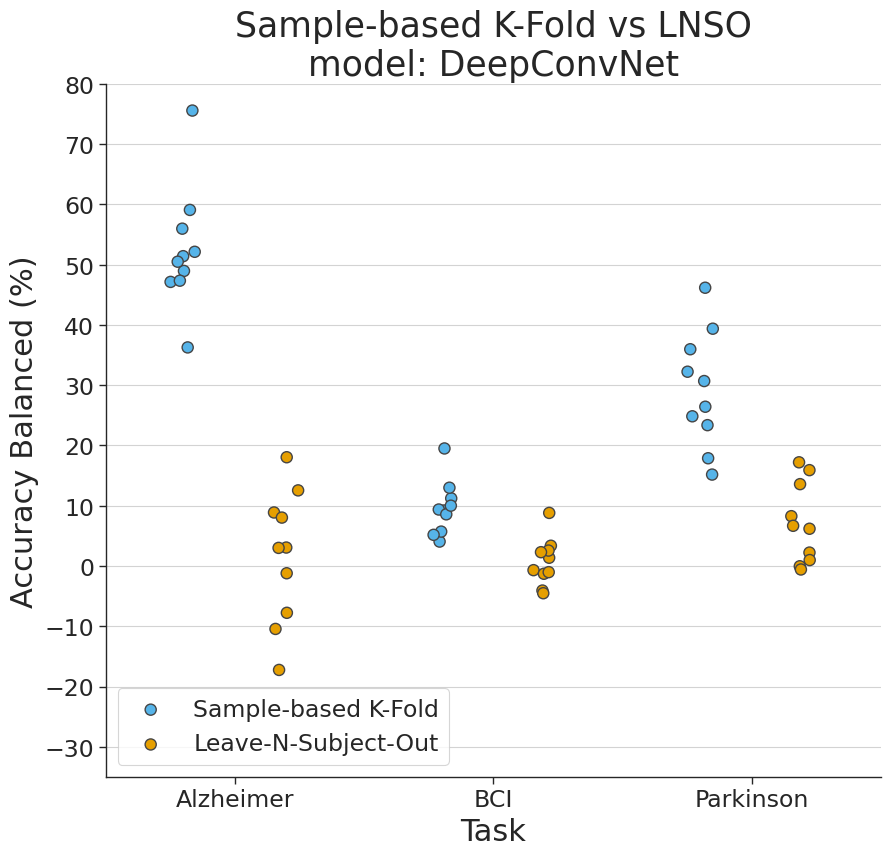

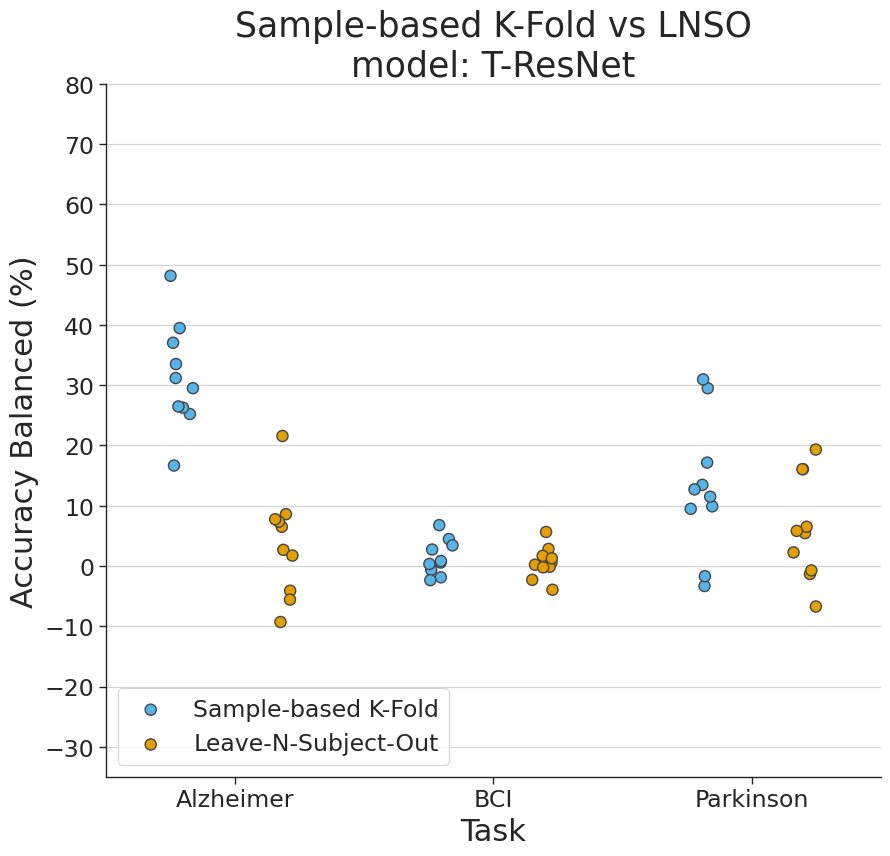

In [9]:
font = 22
for i in model:
    model_df = df2.loc[df2["Model"]==i]
    model_df.loc[:,"Task"] = model_df.loc[:,"Task"].apply(get_full_name)
    fig, ax = plt.subplots(figsize=(10, 9))
    #sns.boxplot(x='Task', y='Metric', hue='Partition', data=model_df, showfliers=False, ax=ax)
    sns.stripplot(
        x         = 'Task',
        y         = 'MetricDiff',
        data      = model_df,
        legend    = False,
        linewidth = 1,
        hue       = 'Partition',
        dodge     = True,
        ax        = ax,
        size      = 8,
        palette   = ["#56b4e9", "#e69f00"]
    )
    ax.set_yticks([i*10 for i in range(-3, 9)])
    ax.set_title( f'Sample-based K-Fold vs LNSO\nmodel: {get_full_name(i)}',fontsize = font+3)
    ax.set_xlabel('Task', fontsize = font)
    ax.set_ylabel('Accuracy Balanced (%)', fontsize = font)
    ax.set_ylim(-35,80)
    ax.tick_params(axis='both', which='major', labelsize=font-5)
    plt.legend(["Sample-based K-Fold", "Leave-N-Subject-Out"], fontsize = font-5, loc = "lower left")
    plt.savefig(f"Images/{folder}/Bias_Kfold_vs_LNSO_model_{get_full_name(i)}.pdf")
    plt.show()

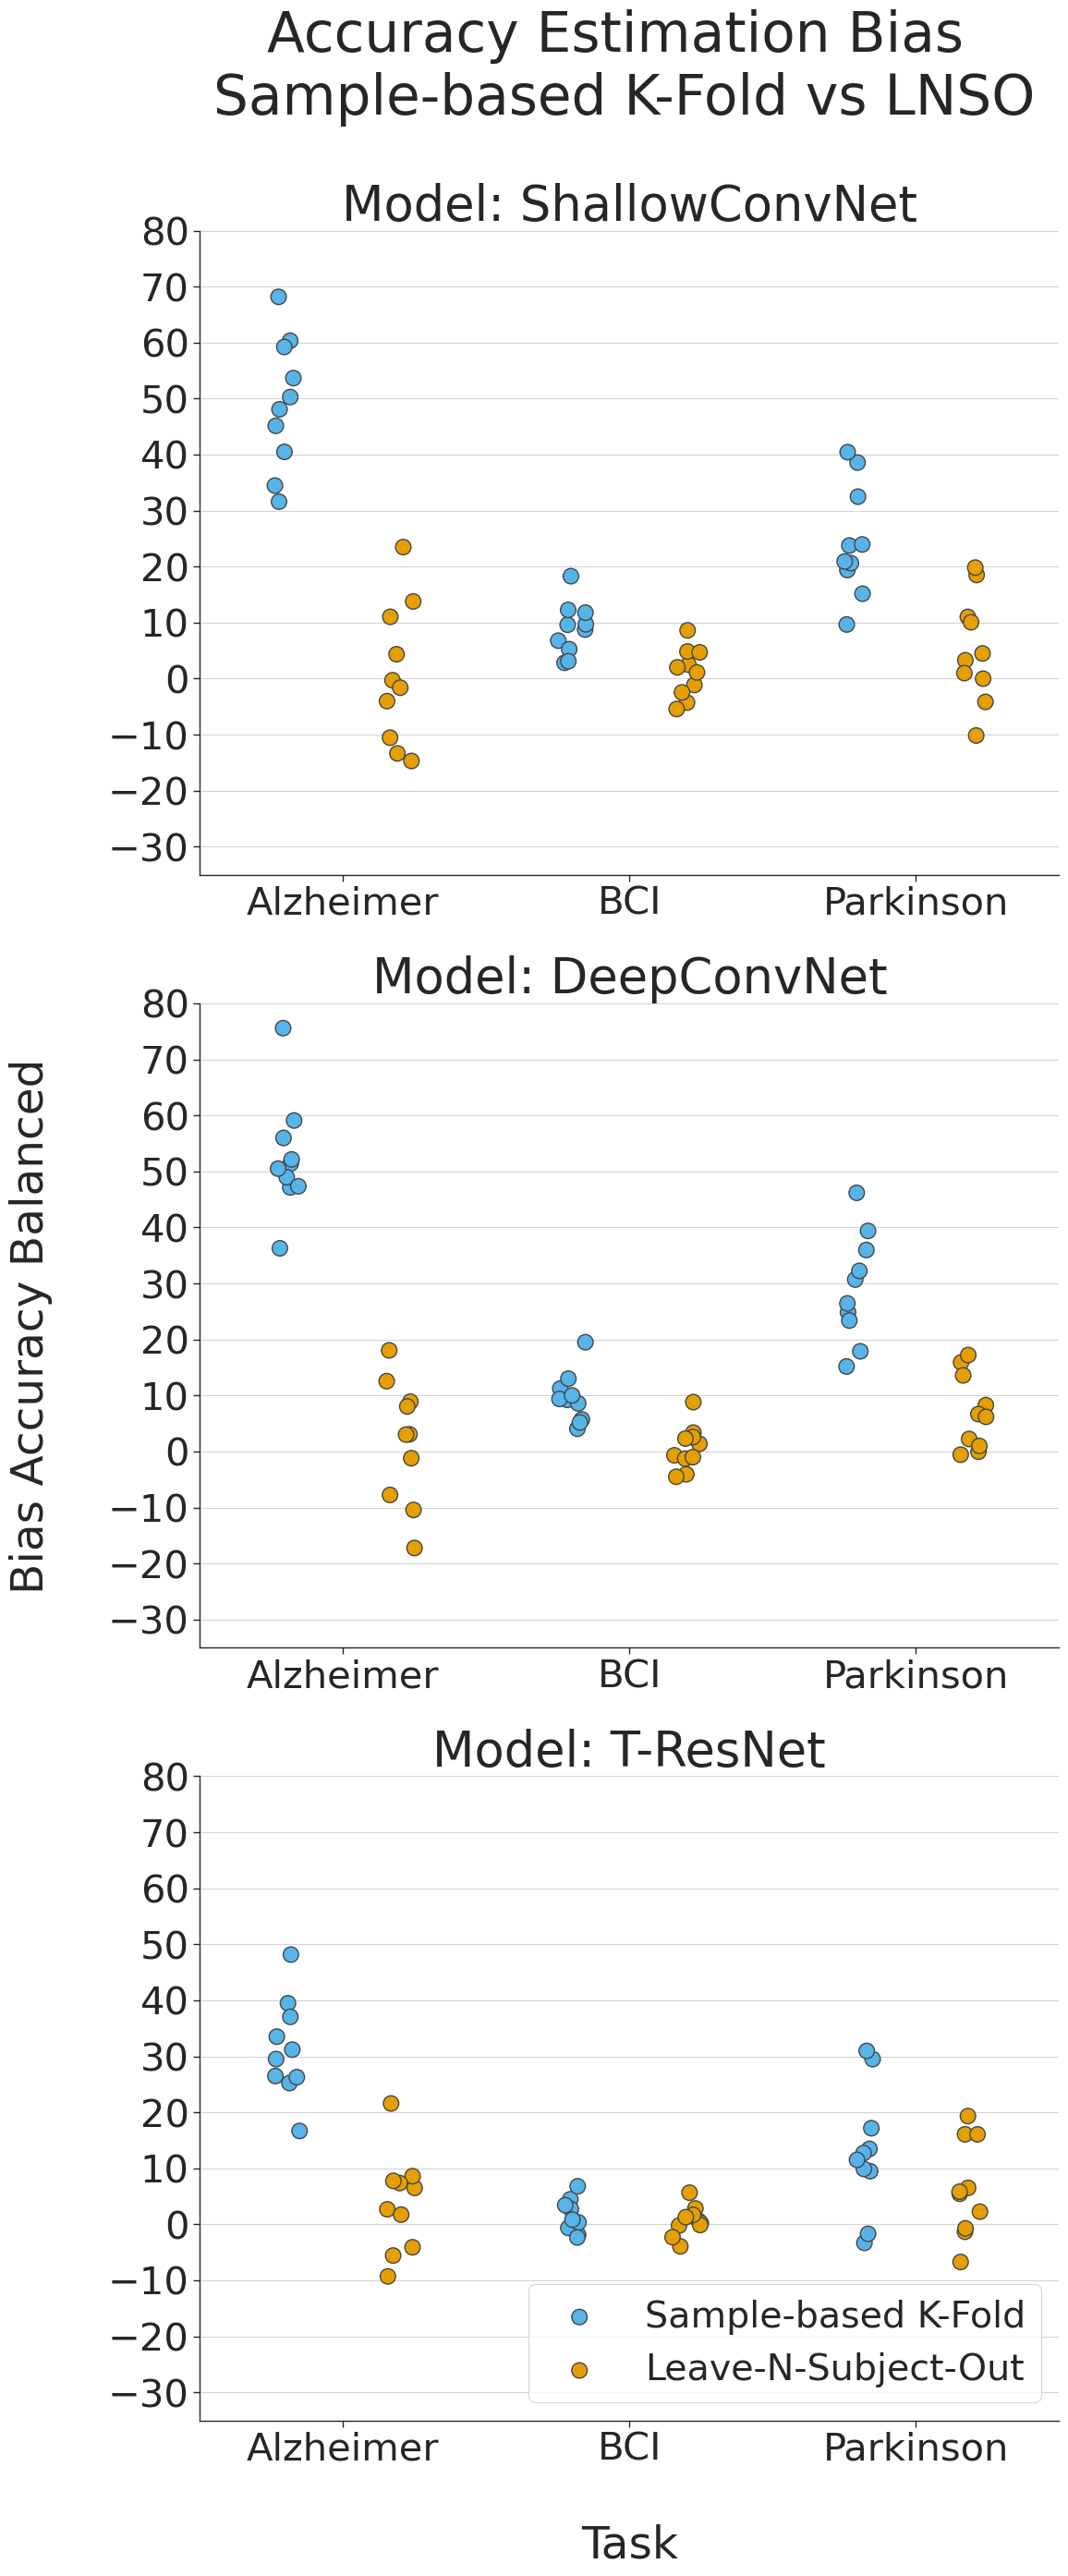

In [10]:
font = 35
fig, ax = plt.subplots(3, 1, figsize=(12, 30))
for n, i in enumerate(model):
    model_df = df2.loc[df2["Model"]==i]
    model_df.loc[:,"Task"] = model_df.loc[:,"Task"].apply(get_full_name)
    sns.stripplot(
        x         = 'Task',
        y         = 'MetricDiff',
        data      = model_df,
        legend    = False,
        linewidth = 1,
        hue       = 'Partition',
        dodge     = True,
        ax        = ax[n],
        size      = 12,
        palette   = ["#56b4e9", "#e69f00"]
    )
    ax[n].set_yticks([i*10 for i in range(-3, 9)])
    ax[n].set_title( f'Model: {get_full_name(i)}',fontsize = font+3)
    if n == 2:
        ax[n].set_xlabel(f'\nTask', fontsize = font)
    else:
        ax[n].set(xlabel=None)
    if n == 1:
        ax[n].set_ylabel('Bias Accuracy Balanced\n', fontsize = font)
    else:
        ax[n].set(ylabel=None)
    if n==2:
        ax[n].legend(["Sample-based K-Fold", "Leave-N-Subject-Out"], fontsize = font-6.5, loc = "lower right")
    ax[n].set_ylim(-35,80)
    ax[n].tick_params(axis='both', which='major', labelsize=font-5)
fig.suptitle( f'Accuracy Estimation Bias\n Sample-based K-Fold vs LNSO',fontsize = font+8)
plt.subplots_adjust(top=0.9)
plt.savefig(f"Images/{folder}/Bias_Kfold_vs_LNSO_concat.pdf", bbox_inches = 'tight')
plt.show()

## LNSO vs N-LNSO

In [9]:
metric = 'accuracy_weighted'
task = ['pds', 'alz', 'bci']
model = ['shn','dcn','res']
partition = ['LNSO', 'NLNSO']

performances, performancesval = gather_metric_values(metric, task, model, partition, True)
performances_df = convert_performance_totable(performances)
performancesval_df = convert_performance_totable(performancesval)

In [10]:
performances_df["Task "] = performances_df["Task"].apply(
    lambda x: {'pds': 'Parkinson', 'alz':'Alzheimer', 'bci':'BCI'}.get(x))

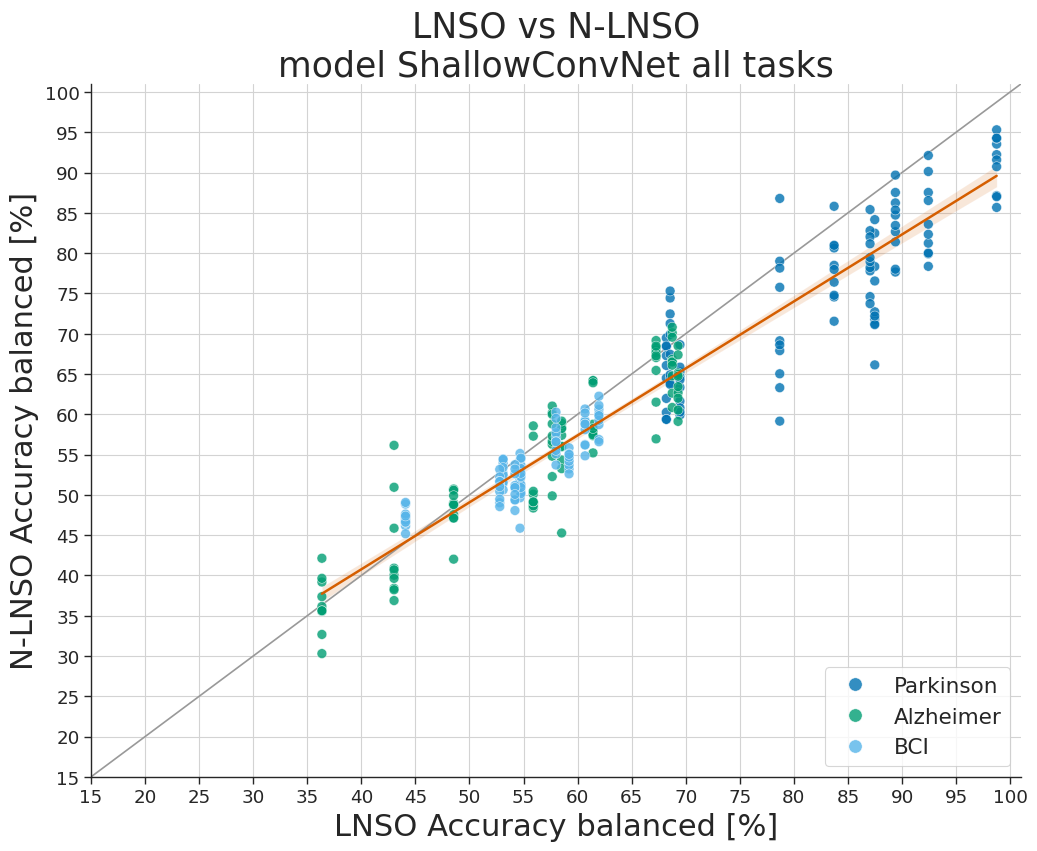

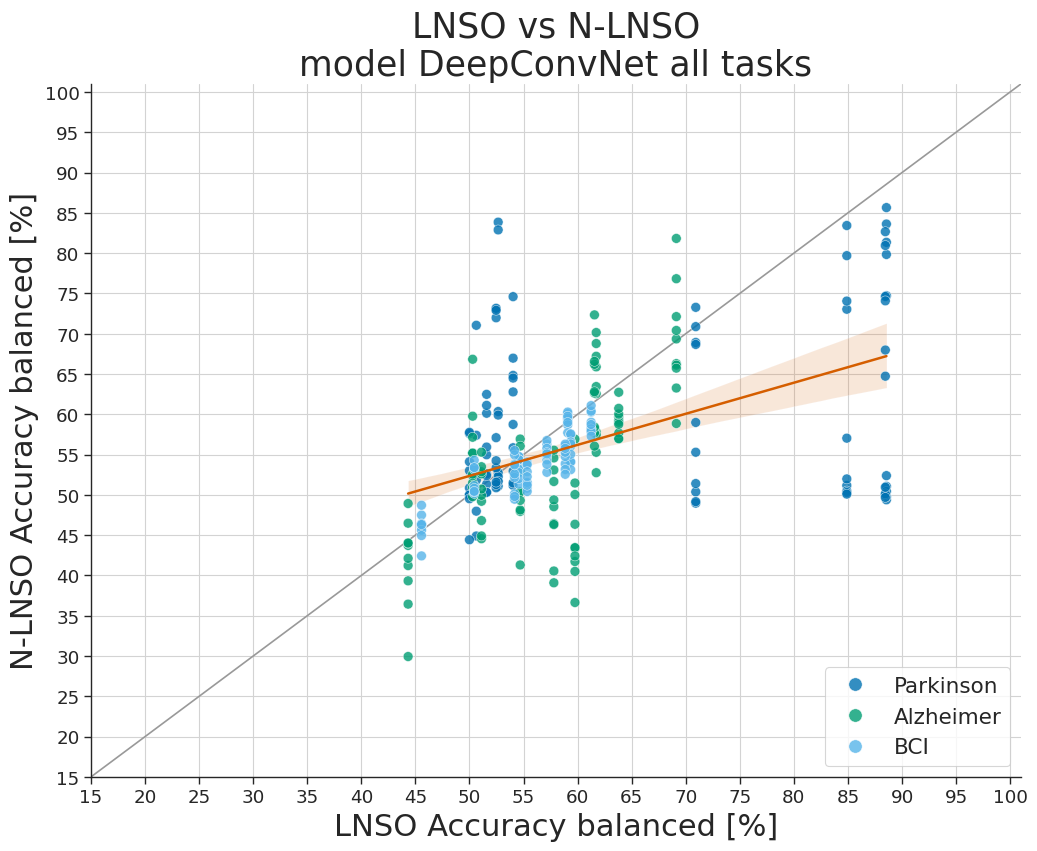

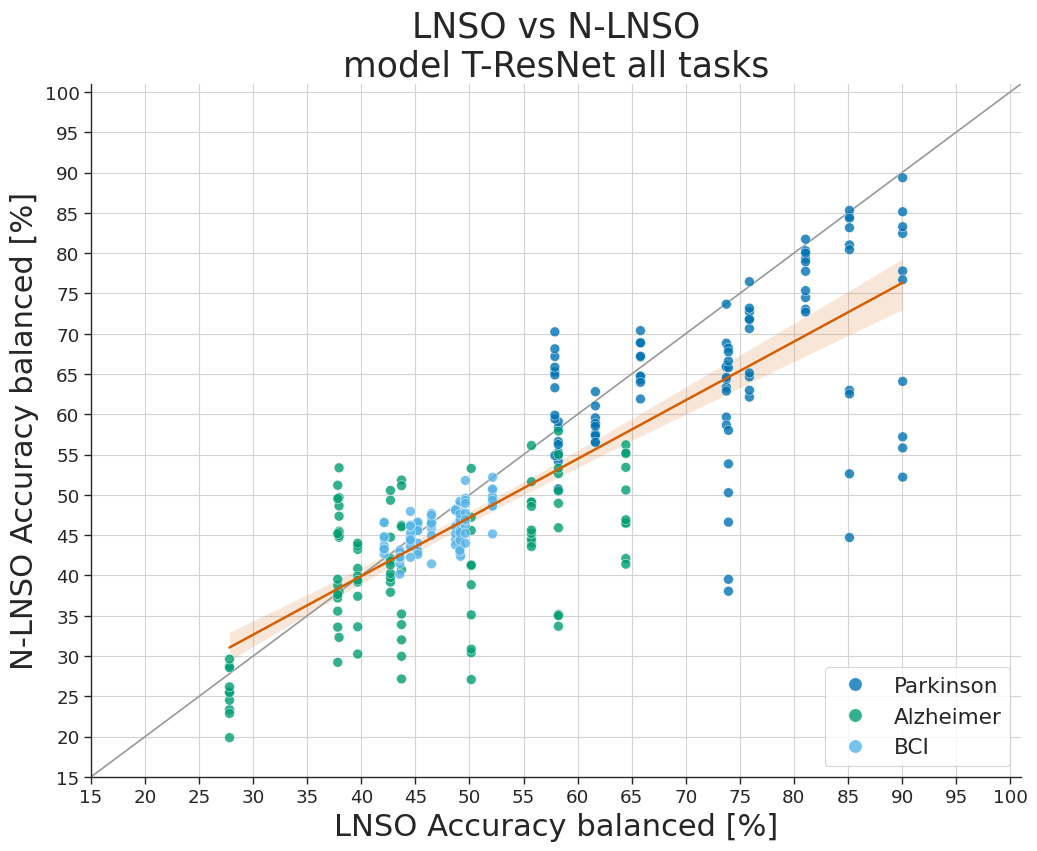

In [11]:
for i in model:
    nlnso_pd_tot = []
    lnso_tot = []
    for k in task:
        lnso = performances_df.loc[(
            (performances_df['Task']==k) &
            (performances_df['Model']==i) & 
            (performances_df['Partition']=="LNSO")
        ), "Metric"].values
        lnso_tot += lnso.tolist()
        nlnso_pd = performances_df.loc[(
            (performances_df['Task']==k) &
            (performances_df['Model']==i) & 
            (performances_df['Partition']=="NLNSO")
        )]
        nlnso_pd.loc[:,'Outer'] = lnso[nlnso_pd['Outer'].values-1]
        if not(isinstance(nlnso_pd_tot, pd.DataFrame)):
            nlnso_pd_tot = nlnso_pd
        else:
            try:
                nlnso_pd_tot = pd.concat([nlnso_pd_tot, nlnso_pd])
            except:
                nlnso_pd_tot = nlnso_pd
    lnso_tot = np.array(lnso_tot)
    nlnso = nlnso_pd_tot["Metric"].values
    nlnso = nlnso.reshape(-1,10)
    nlnso_med = np.median(nlnso,1)
    nlnso_min = np.min(nlnso,1)
    nlnso_max = np.max(nlnso,1)
    nlnso_25 = np.percentile(nlnso,25, 1)
    nlnso_75 = np.percentile(nlnso,75, 1)
    nlnso_err = np.stack((nlnso_med-nlnso_min, nlnso_max-nlnso_med),1).T
    nlnso_err = np.stack((nlnso_med-nlnso_25, nlnso_75-nlnso_med),1).T
    nlnso_iqr = np.subtract(*np.percentile(nlnso, [75, 25], 1))
    font = 22

    range_x = np.arange(10)
    fig, ax = plt.subplots(figsize=(12, 9))
    sns.scatterplot(
        data=nlnso_pd_tot, x="Outer", y="Metric", hue="Task ",
        ax=ax, legend=True, alpha = 0.8, palette=["#0072b2", "#009e73", "#56b4e9"],
        zorder=2
    )
    lgnd = ax.legend(fontsize = font-6.5, loc = "lower right", markerscale=2)
    sns.regplot(
        data=nlnso_pd_tot, x="Outer", y="Metric",
        ax=ax, color='#1f77b4', ci=95,
        scatter=False, fit_reg=True,
        scatter_kws={'alpha':0.5, 'hue':"Task", 'size':8},
        #line_kws = {'color': '#ca9161'}
        line_kws = {'color': "#d55e00"}
    )
    ax.collections[0].set_sizes([50])
    ax.plot(np.arange(120), np.arange(120), color= '#999999', zorder=1 )
    ax.set_yticks([i*5 for i in range(0, 21)])
    ax.set_xticks([i*5 for i in range(0, 21)])
    ax.set_title(
        f'LNSO vs N-LNSO\nmodel {get_full_name(i)} all tasks',
        fontsize = font+3
    )
    ax.set_xlabel('LNSO Accuracy balanced [%]', fontsize = font)
    ax.set_ylabel('N-LNSO Accuracy balanced [%]', fontsize = font)
    ax.set_ylim(15,101)
    ax.set_xlim(15,101)
    plt.savefig(f"Images/{folder}/LNSO_vs_NLNSO_model_{get_full_name(i)}_all_tasks.pdf")
    plt.show()

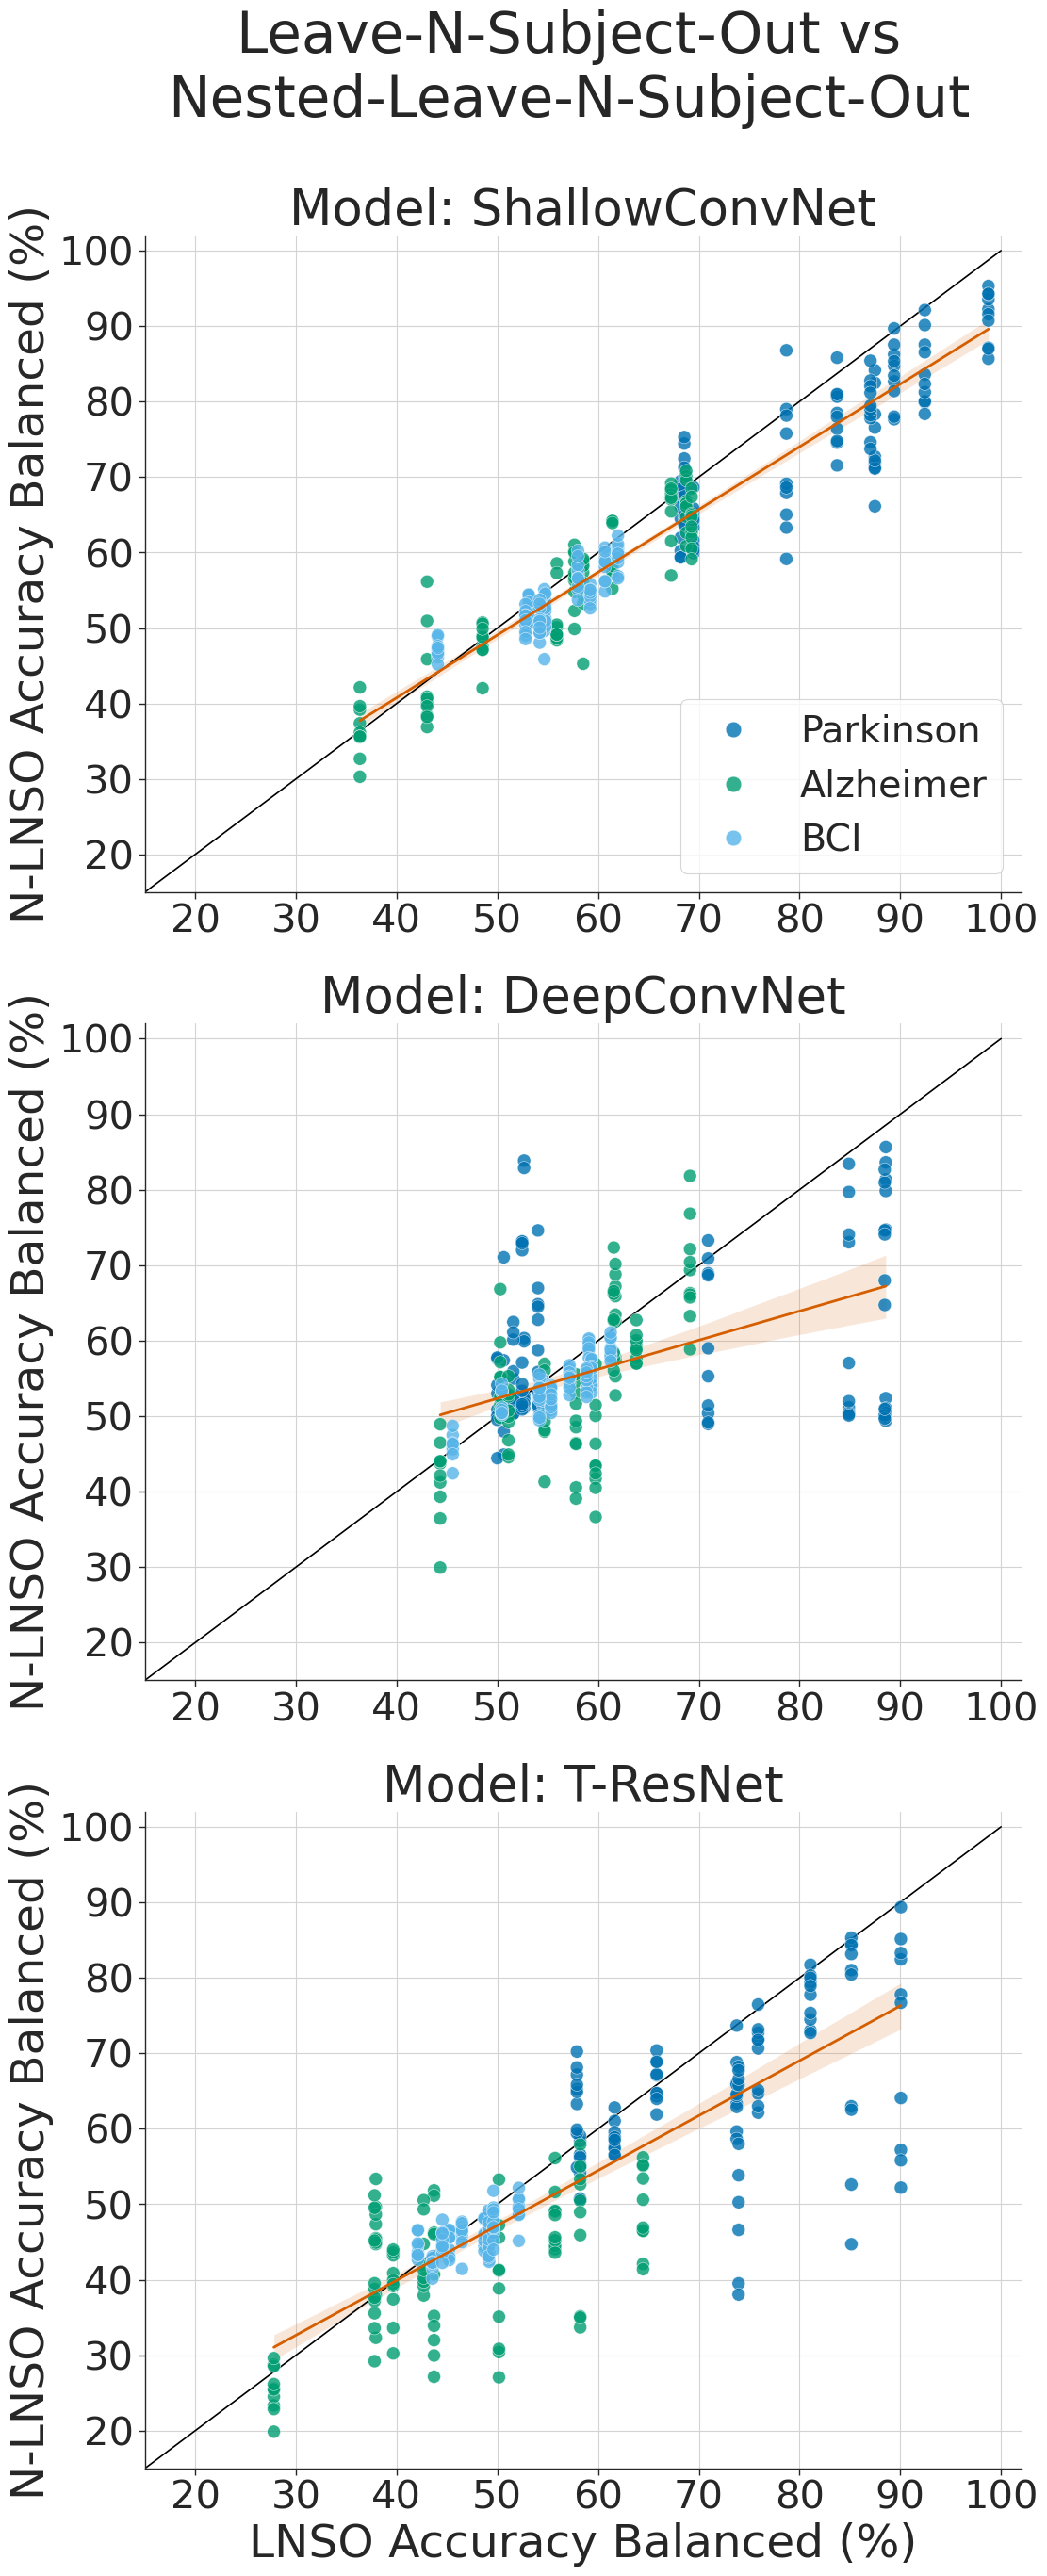

In [15]:
font = 35
fig, ax = plt.subplots(3, 1, figsize=(12, 30))
for n, i in enumerate(model):
    nlnso_pd_tot = []
    lnso_tot = []
    for k in task:
        lnso = performances_df.loc[(
            (performances_df['Task']==k) &
            (performances_df['Model']==i) & 
            (performances_df['Partition']=="LNSO")
        ), "Metric"].values
        lnso_tot += lnso.tolist()
        nlnso_pd = performances_df.loc[(
            (performances_df['Task']==k) &
            (performances_df['Model']==i) & 
            (performances_df['Partition']=="NLNSO")
        )]
        nlnso_pd.loc[:,'Outer'] = lnso[nlnso_pd['Outer'].values-1]
        if not(isinstance(nlnso_pd_tot, pd.DataFrame)):
            nlnso_pd_tot = nlnso_pd
        else:
            try:
                nlnso_pd_tot = pd.concat([nlnso_pd_tot, nlnso_pd])
            except:
                nlnso_pd_tot = nlnso_pd
    lnso_tot = np.array(lnso_tot)
    nlnso = nlnso_pd_tot["Metric"].values
    nlnso = nlnso.reshape(-1,10)
    range_x = np.arange(10)
    sns.scatterplot(
        data=nlnso_pd_tot, x="Outer", y="Metric", hue="Task ",
        ax=ax[n], legend=True if n == 0 else False, alpha = 0.8,
        palette=["#0072b2", "#009e73", "#56b4e9"],
        zorder=2
    )
    if n == 0:
        lgnd = ax[n].legend(fontsize = font-6.5, loc = "lower right", markerscale=2.5)
    sns.regplot(
        data=nlnso_pd_tot, x="Outer", y="Metric",
        ax=ax[n], color='#1f77b4', ci=95,
        scatter=False, fit_reg=True,
        scatter_kws={'alpha':0.4, 'hue':"Task", 'size':15},
        #line_kws = {'color': '#ca9161'}
        line_kws = {'color': "#d55e00", 'linewidth': 2}
    )
    ax[n].collections[0].set_sizes([100])
    ax[n].plot(np.arange(101), np.arange(101), zorder = 1,
               color= "black")# '#999999')

    if n == 2:
        ax[n].set_xlabel('LNSO Accuracy Balanced (%)', fontsize = font)
    else:
        ax[n].set(xlabel=None)
    ax[n].set_ylabel('N-LNSO Accuracy Balanced (%)', fontsize = font)
    ax[n].set_yticks([i*10 for i in range(0, 11)])
    ax[n].set_xticks([i*10 for i in range(0, 11)])
    ax[n].set_title(f'Model: {get_full_name(i)}', fontsize = font+3)
    ax[n].set_ylim(15,102)
    ax[n].set_xlim(15,102)
    ax[n].tick_params(axis='both', which='major', labelsize=font-5)
fig.suptitle(f'Leave-N-Subject-Out vs\nNested-Leave-N-Subject-Out', fontsize= font+8)
plt.subplots_adjust(top=0.90)
plt.savefig(f"Images/{folder}/LNSO_vs_NLNSO_all_tasks_vertical.pdf")
plt.show()

## Quantitative analysis using additional nested level

Comparing the results of subject-based and nested-subject-based cross-validation methods
is not possible. Groups have folds that are not completely independent, nor they can be considered paired.
Both the Wilcoxon signed-rank  or the Mann Whiteny U cannot be used in this context.

In [16]:
metric = 'accuracy_weighted'
task = ['pds', 'alz', 'bci']
model = ['shn','dcn','res']
partition = ['NLNSO', 'NNLNSO']

performances, performancesval, performancestest = gather_metric_values(
    metric, task, model, partition, True, True
)
performances_df = convert_performance_totable(performances, performancesval, performancestest)

In [17]:
df1 = (performances_df.loc[performances_df['Partition']=='NLNSO']).copy()
df2 = (performances_df.loc[performances_df['Partition']=='NNLNSO']).copy()
df2.loc[:,"MetricValTest"] = df2.loc[:,"MetricTest"] + df2.loc[:,"MetricVal"]
grouped_nlnso = df1.groupby(["Partition", "Task", "Model", "Outer"])
grouped_nnlnso = df2.groupby(["Partition", "Task", "Model", "Repetition"])

df1 = grouped_nlnso.apply(lambda x: x.Metric.mean(), include_groups=False)
df1 = df1.reset_index().rename(columns={0: "Metric"})

df3 = grouped_nlnso.apply(lambda x: x.MetricVal.mean(), include_groups=False)
df3 = df3.reset_index().rename(columns={0: "MetricEstimate"})
df1.loc[:,"MetricEstimate"] = df3.loc[:,"MetricEstimate"]
df1["MetricDiff"] = df1["MetricEstimate"]- df1["Metric"]

df4 = grouped_nlnso.apply(lambda x: x.Inner[x.MetricVal.idxmax()], include_groups=False)
df4 = df4.reset_index().rename(columns={0: "Inner"})
df1.loc[:,"Repetition"] = 1
df1.loc[:,"Inner"] = df4.loc[:,"Inner"]


df2 = grouped_nnlnso.apply(lambda x: x.Metric.mean(), include_groups=False)
df2 = df2.reset_index().rename(columns={0: "Metric"})

df3 = grouped_nnlnso.apply(lambda x: x.Outer[x.MetricValTest.idxmax()], include_groups=False)
df3 = df3.reset_index().rename(columns={0: "Outer"})
df2.loc[:,'Outer'] = df3.loc[:,"Outer"]

df4 = grouped_nnlnso.apply(lambda x: x.Inner[x.MetricValTest.idxmax()], include_groups=False)
df4 = df4.reset_index().rename(columns={0: "Inner"})
df2.loc[:,"Inner"] = df4.loc[:,"Inner"]

df4 = grouped_nnlnso.apply(lambda x: x.MetricTest.mean(), include_groups=False)
df4 = df4.reset_index().rename(columns={0: "MetricEstimate"})
df2.loc[:,"MetricEstimate"] = df4.loc[:,"MetricEstimate"]
df2["MetricDiff"] = df2["MetricEstimate"]- df2["Metric"]

df2 = pd.concat([df1, df2])
del df3, df4

In [18]:
for i in model:
    for k in task:
        diff_nlnso = df2.loc[(df2["Model"]==i) & (df2["Task"]==k) & (df2["Partition"]=="NLNSO"), "MetricDiff"].values
        diff_nnlnso = df2.loc[(df2["Model"]==i) & (df2["Task"]==k) & (df2["Partition"]=="NNLNSO"), "MetricDiff"].values
        print(
            f'{get_full_name(i):15} - {get_full_name(k):10}:',
            f'{np.abs(diff_nlnso).mean():10.4f} / ',
            f'{np.abs(diff_nnlnso).mean():10.4f} / ',
            f'{np.median(np.abs(diff_nlnso)):10.4f} / ',
            f'{np.median(np.abs(diff_nnlnso)):10.4f} ',
        )

print('\n\n')
for i in model:
    for k in task:
        diff_nlnso = df2.loc[(df2["Model"]==i) & (df2["Task"]==k) & (df2["Partition"]=="NLNSO"), "MetricDiff"].values
        diff_nnlnso = df2.loc[(df2["Model"]==i) & (df2["Task"]==k) & (df2["Partition"]=="NNLNSO"), "MetricDiff"].values
        print(
            f'{get_full_name(i):15} - {get_full_name(k):10}:',
            f'{np.abs(diff_nlnso).std():10.4f} / ',
            f'{np.abs(diff_nnlnso).std():10.4f} / ',
            f'{np.subtract(*np.percentile(np.abs((diff_nlnso)),[75, 25])):10.4f} / ',
            f'{np.subtract(*np.percentile(np.abs((diff_nnlnso)),[75, 25])):10.4f} ',
        )

ShallowConvNet  - Parkinson :     8.2464 /      8.1151 /      7.2718 /      7.3814 
ShallowConvNet  - Alzheimer :     9.7196 /      9.2609 /     10.7886 /      9.2235 
ShallowConvNet  - BCI       :     3.7076 /      3.4296 /      3.3909 /      2.8182 
DeepConvNet     - Parkinson :     7.1657 /      5.4603 /      6.4274 /      4.5681 
DeepConvNet     - Alzheimer :     9.0245 /      6.6185 /      8.4589 /      6.5344 
DeepConvNet     - BCI       :     2.9988 /      3.0401 /      2.4276 /      2.1631 
T-ResNet        - Parkinson :     8.0281 /      6.5407 /      6.1694 /      5.6036 
T-ResNet        - Alzheimer :     7.5191 /      5.4188 /      6.9363 /      4.6958 
T-ResNet        - BCI       :     1.8831 /      1.9176 /      1.4841 /      1.6028 



ShallowConvNet  - Parkinson :     6.5567 /      5.3466 /      7.3068 /      7.1936 
ShallowConvNet  - Alzheimer :     6.7957 /      6.4629 /      9.5643 /     10.8862 
ShallowConvNet  - BCI       :     2.2114 /      2.2219 /      2.6783 /   

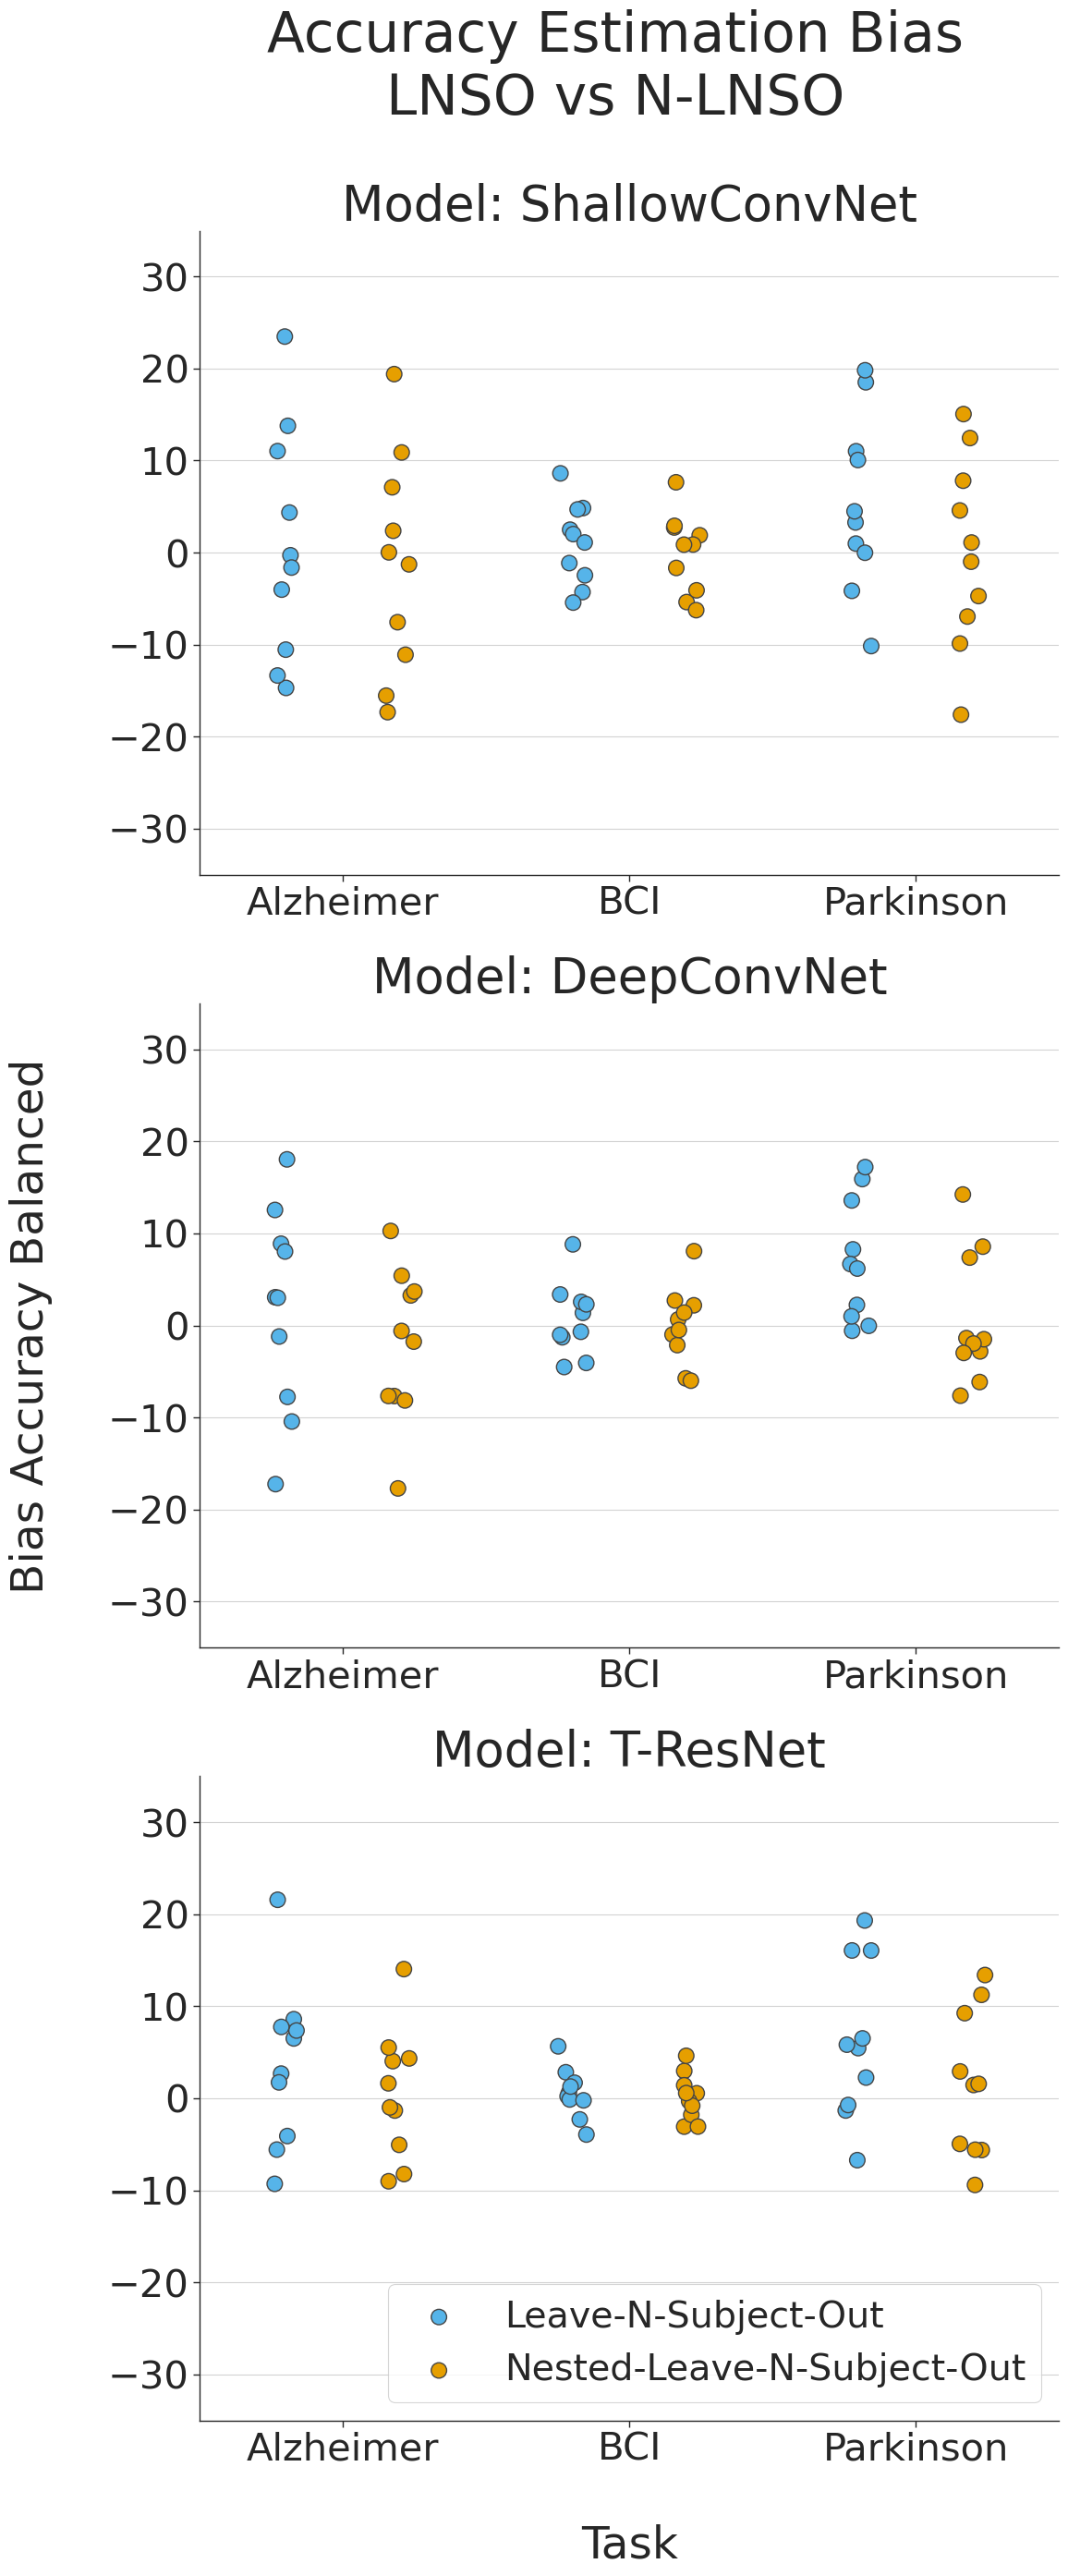

In [19]:
font = 35
fig, ax = plt.subplots(3, 1, figsize=(12, 30))
for n, i in enumerate(model):
    model_df = df2.loc[df2["Model"]==i]
    model_df.loc[:,"Task"] = model_df.loc[:,"Task"].apply(get_full_name)
    sns.stripplot(
        x         = 'Task',
        y         = 'MetricDiff',
        data      = model_df,
        legend    = False,
        linewidth = 1,
        hue       = 'Partition',
        dodge     = True,
        ax        = ax[n],
        size      = 12,
        palette   = ["#56b4e9", "#e69f00"]
    )
    ax[n].set_yticks([i*10 for i in range(-4, 4)])
    ax[n].set_title( f'Model: {get_full_name(i)}',fontsize = font+3)
    if n == 2:
        ax[n].set_xlabel(f'\nTask', fontsize = font)
    else:
        ax[n].set(xlabel=None)
    if n == 1:
        ax[n].set_ylabel('Bias Accuracy Balanced\n', fontsize = font)
    else:
        ax[n].set(ylabel=None)
    if n==2:
        ax[n].legend(["Leave-N-Subject-Out", "Nested-Leave-N-Subject-Out"], fontsize = font-6.5, loc = "lower right")
    ax[n].set_ylim(-35,35)
    ax[n].tick_params(axis='both', which='major', labelsize=font-5)
fig.suptitle( f'Accuracy Estimation Bias\nLNSO vs N-LNSO\n  \n',fontsize = font+8)
plt.savefig(f"Images/{folder}/Bias_LNSO_vs_NLNSO_concat.pdf")
plt.subplots_adjust(top=0.9)
plt.show()

## LOSO vs Full N-LOSO

In [3]:
Nsubj_dict = {'alz': 88, 'pds': 81,'bci': 106}

metric = 'accuracy_weighted'
task = ['pds', 'alz', 'bci']
model = ['shn','dcn', 'res']
partition = ['LOSO', 'NLOSO']

performances, performancesval = gather_metric_values(metric, task, model, partition, True)
performances_df = convert_performance_totable(performances)
performancesval_df = convert_performance_totable(performancesval)

In [4]:
Nsubj_dict = {'alz': 88,'pds': 81,'bci': 106}
for k in task:
    Nsubj = Nsubj_dict[k]
    for i in model:
        loso = performances_df.loc[(
            (performances_df['Task']==k) &
            (performances_df['Model']==i) & 
            (performances_df['Partition']=="LOSO")
        ), "Metric"].values
        nloso_pd = performances_df.loc[(
            (performances_df['Task']==k) &
            (performances_df['Model']==i) & 
            (performances_df['Partition']=="NLOSO")
        )]
        nloso = nloso_pd["Metric"].values
        nloso = nloso.reshape(Nsubj,Nsubj-1)
        nloso_med = np.median(nloso,1)
        nloso_min = np.min(nloso,1)
        nloso_max = np.max(nloso,1)
        nloso_err = np.stack((nloso_med-nloso_min, nloso_max-nloso_med),1).T

        amd = loso
        bmd = nloso_med
        #print(i, k, (((bmd-amd)>0).sum()) )

        amd = np.median(nloso_max)
        bmd = np.percentile(nloso_max, 75) - np.percentile(nloso_max, 25)
        #print(i, k, f'{amd:.3f}, {bmd:.3f}' )
        
        amd = np.median(loso)
        bmd = np.median(nloso.reshape(-1))
        cmd = 100*(amd-bmd)/amd
        #print(i, k, f'{amd:.3f}, {bmd:.3f}, {cmd:.3f}' )
        
        amd = np.percentile(loso, 25)
        bmd = np.percentile(nloso.reshape(-1), 25)
        cmd = 100*(amd-bmd)/amd
        #print(i, k, f'{amd:.3f}, {bmd:.3f}, {cmd:.3f}' )

        amd = np.percentile(loso, 75) - np.percentile(loso, 25)
        bmd = np.percentile(nloso.reshape(-1), 75) - np.percentile(nloso.reshape(-1), 25)
        cmd = 100*(amd-bmd)/amd
        #print(i, k, f'{amd:.3f}, {bmd:.3f}, {cmd:.3f}' )

        amd = np.mean(loso)
        bmd = np.mean(nloso.reshape(-1))
        cmd = 100*(amd-bmd)/amd
        #print(i, k, f'{amd:.3f}, {bmd:.3f}, {cmd:.3f}' )

        amd = np.std(loso)
        bmd = np.std(nloso.reshape(-1))
        cmd = 100*(amd-bmd)/amd
        #print(i, k, f'{amd:.3f}, {bmd:.3f}, {cmd:.3f}' )

    #print(' ')

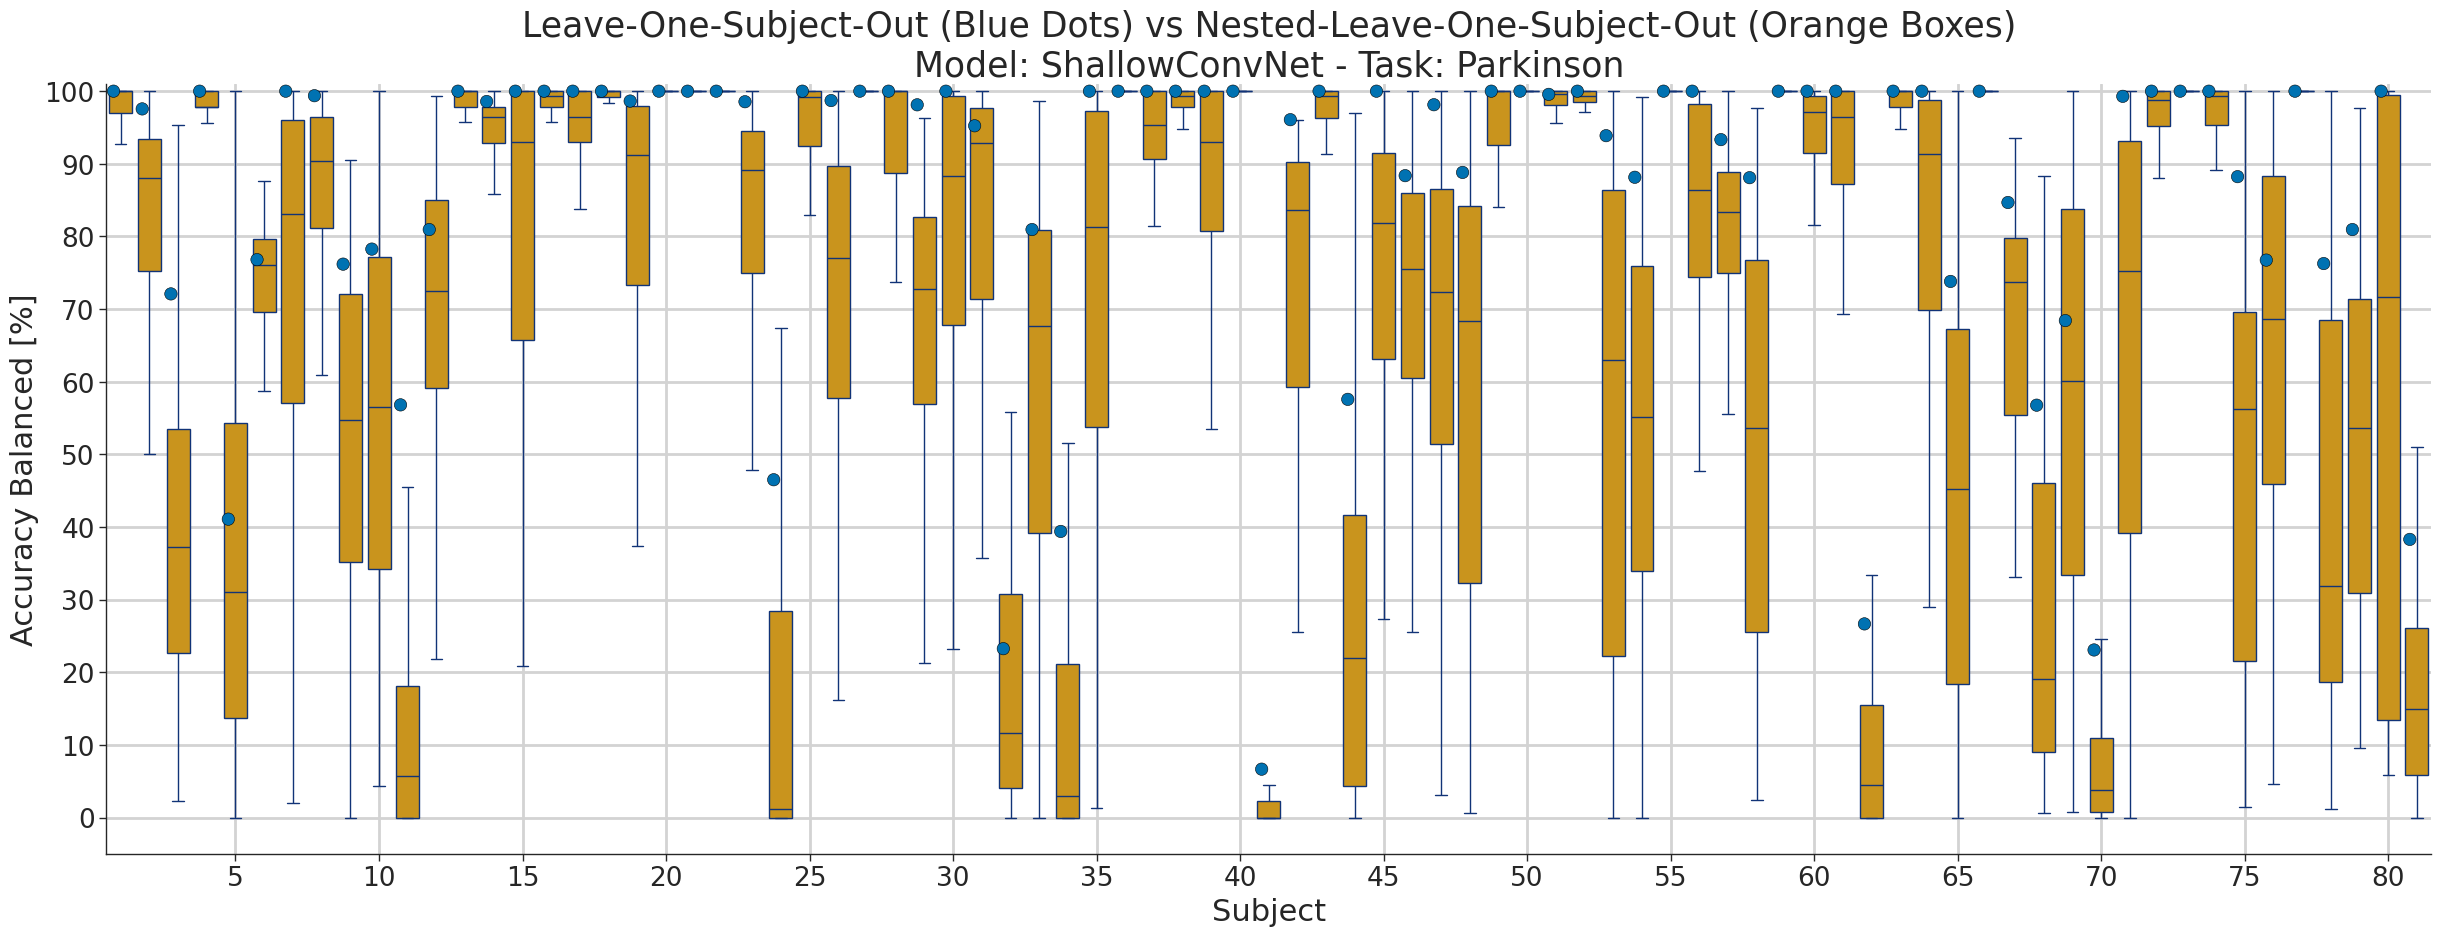

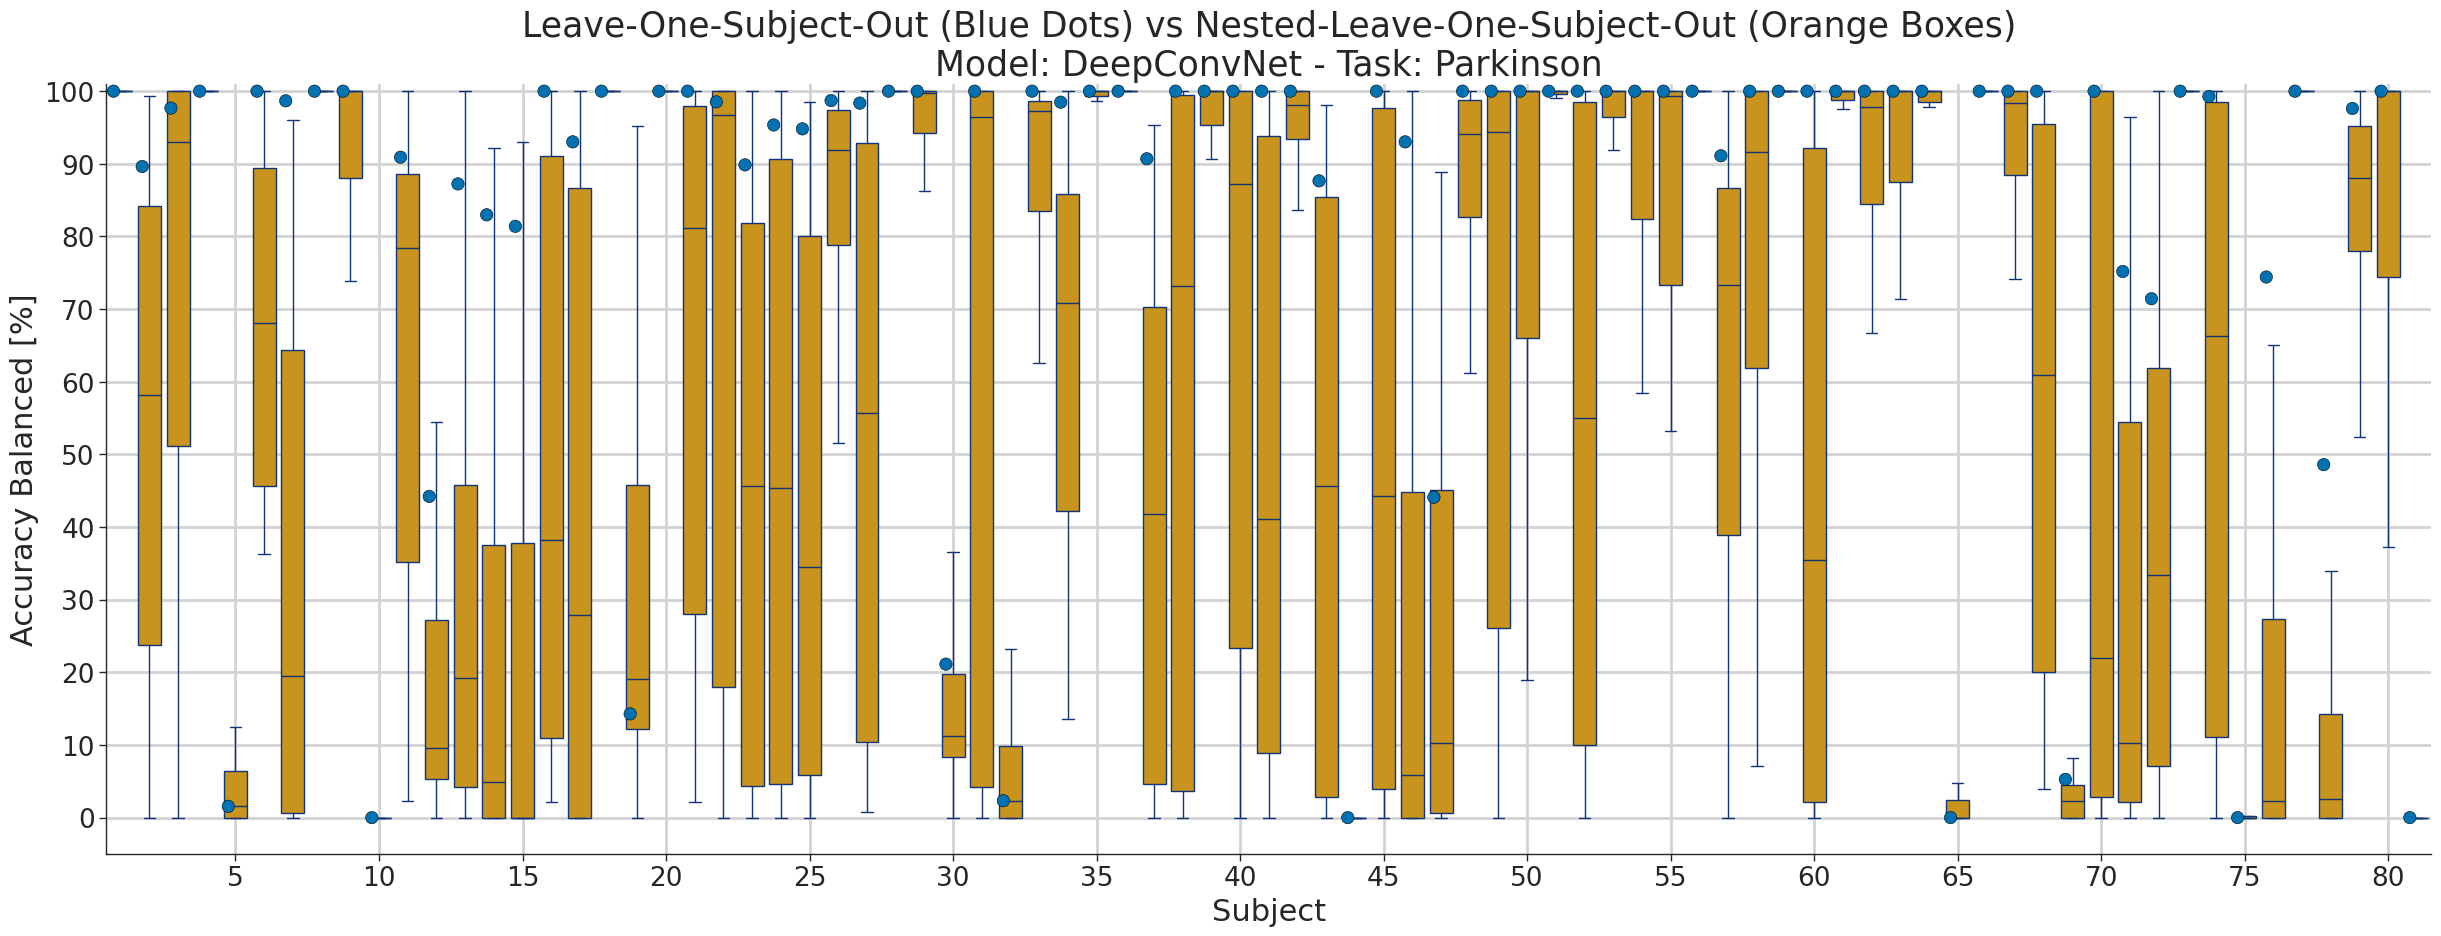

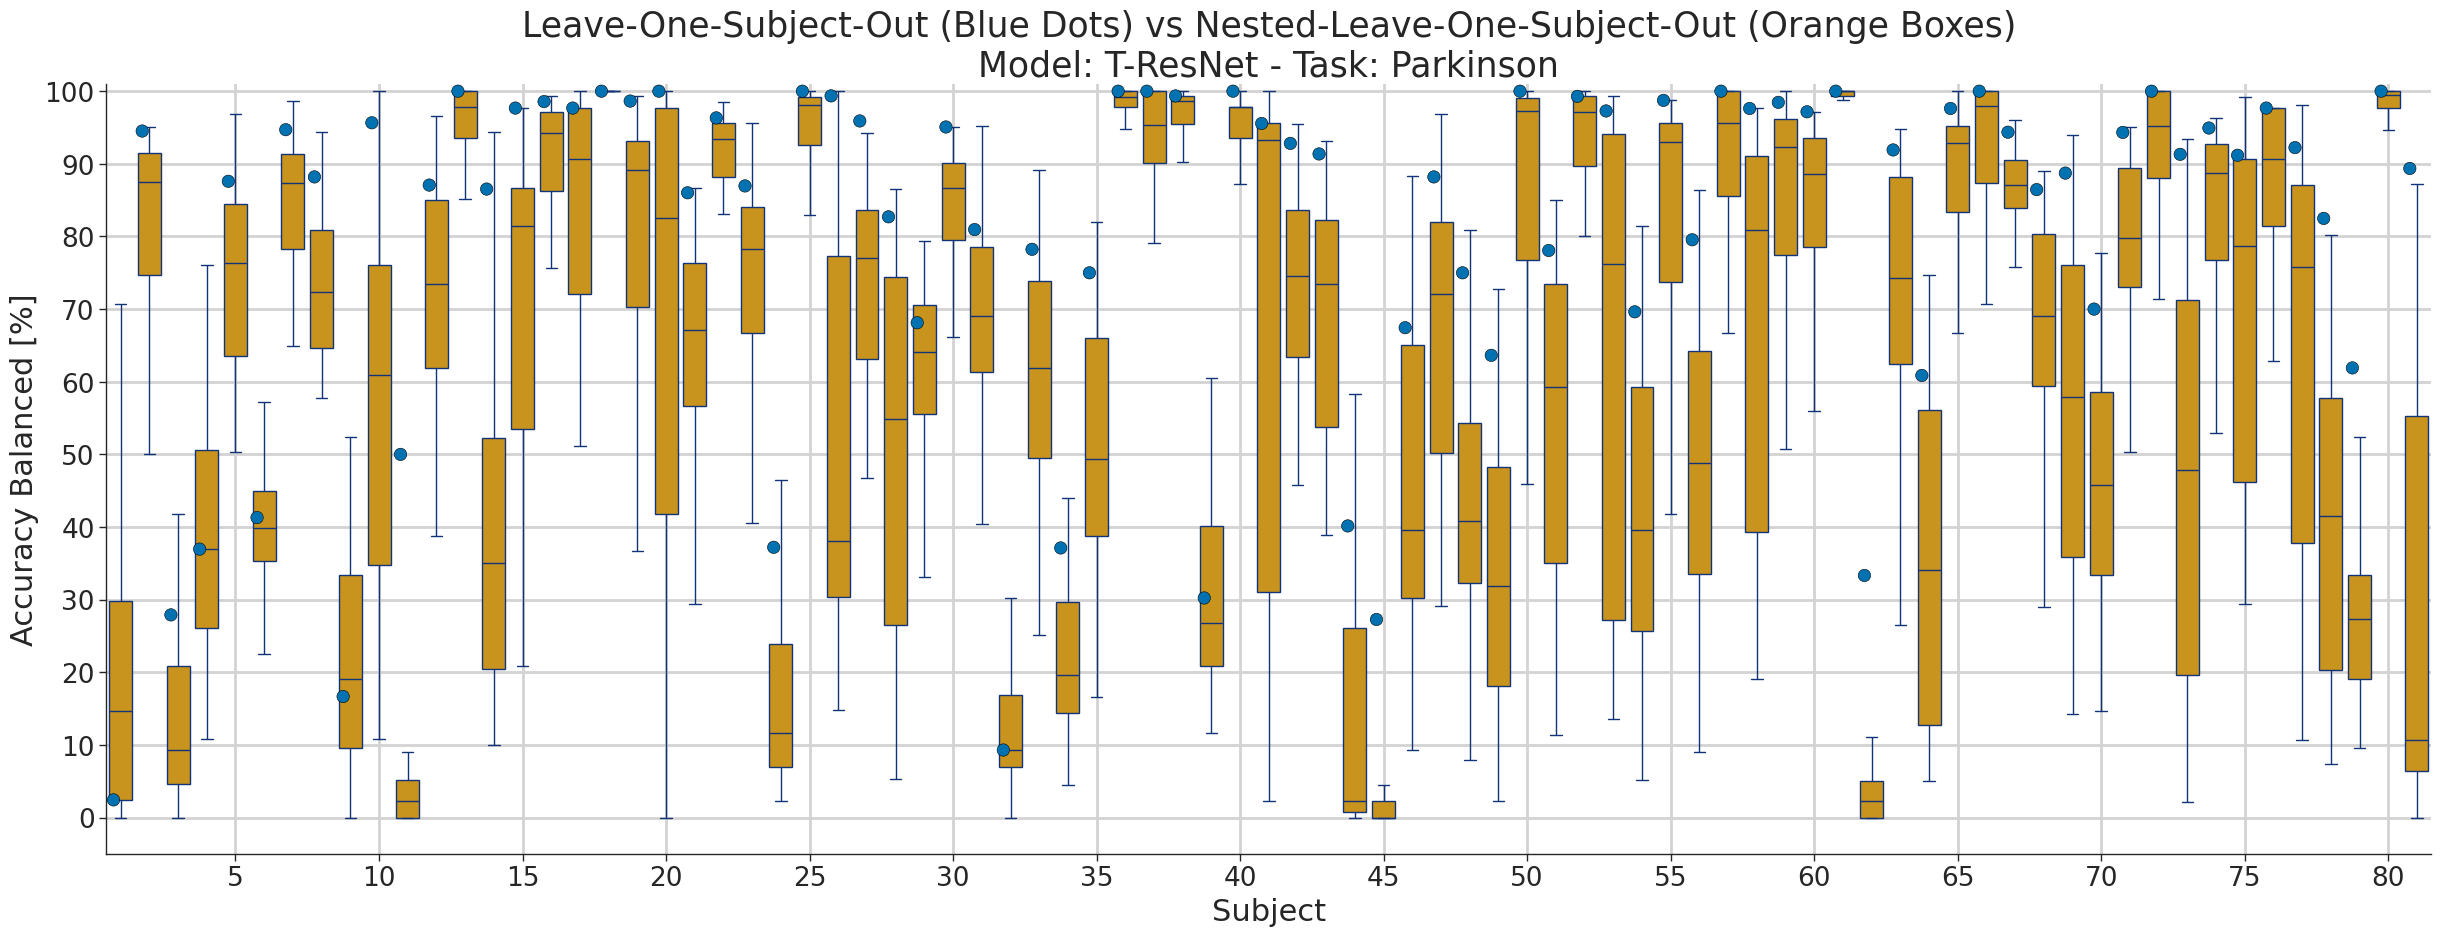

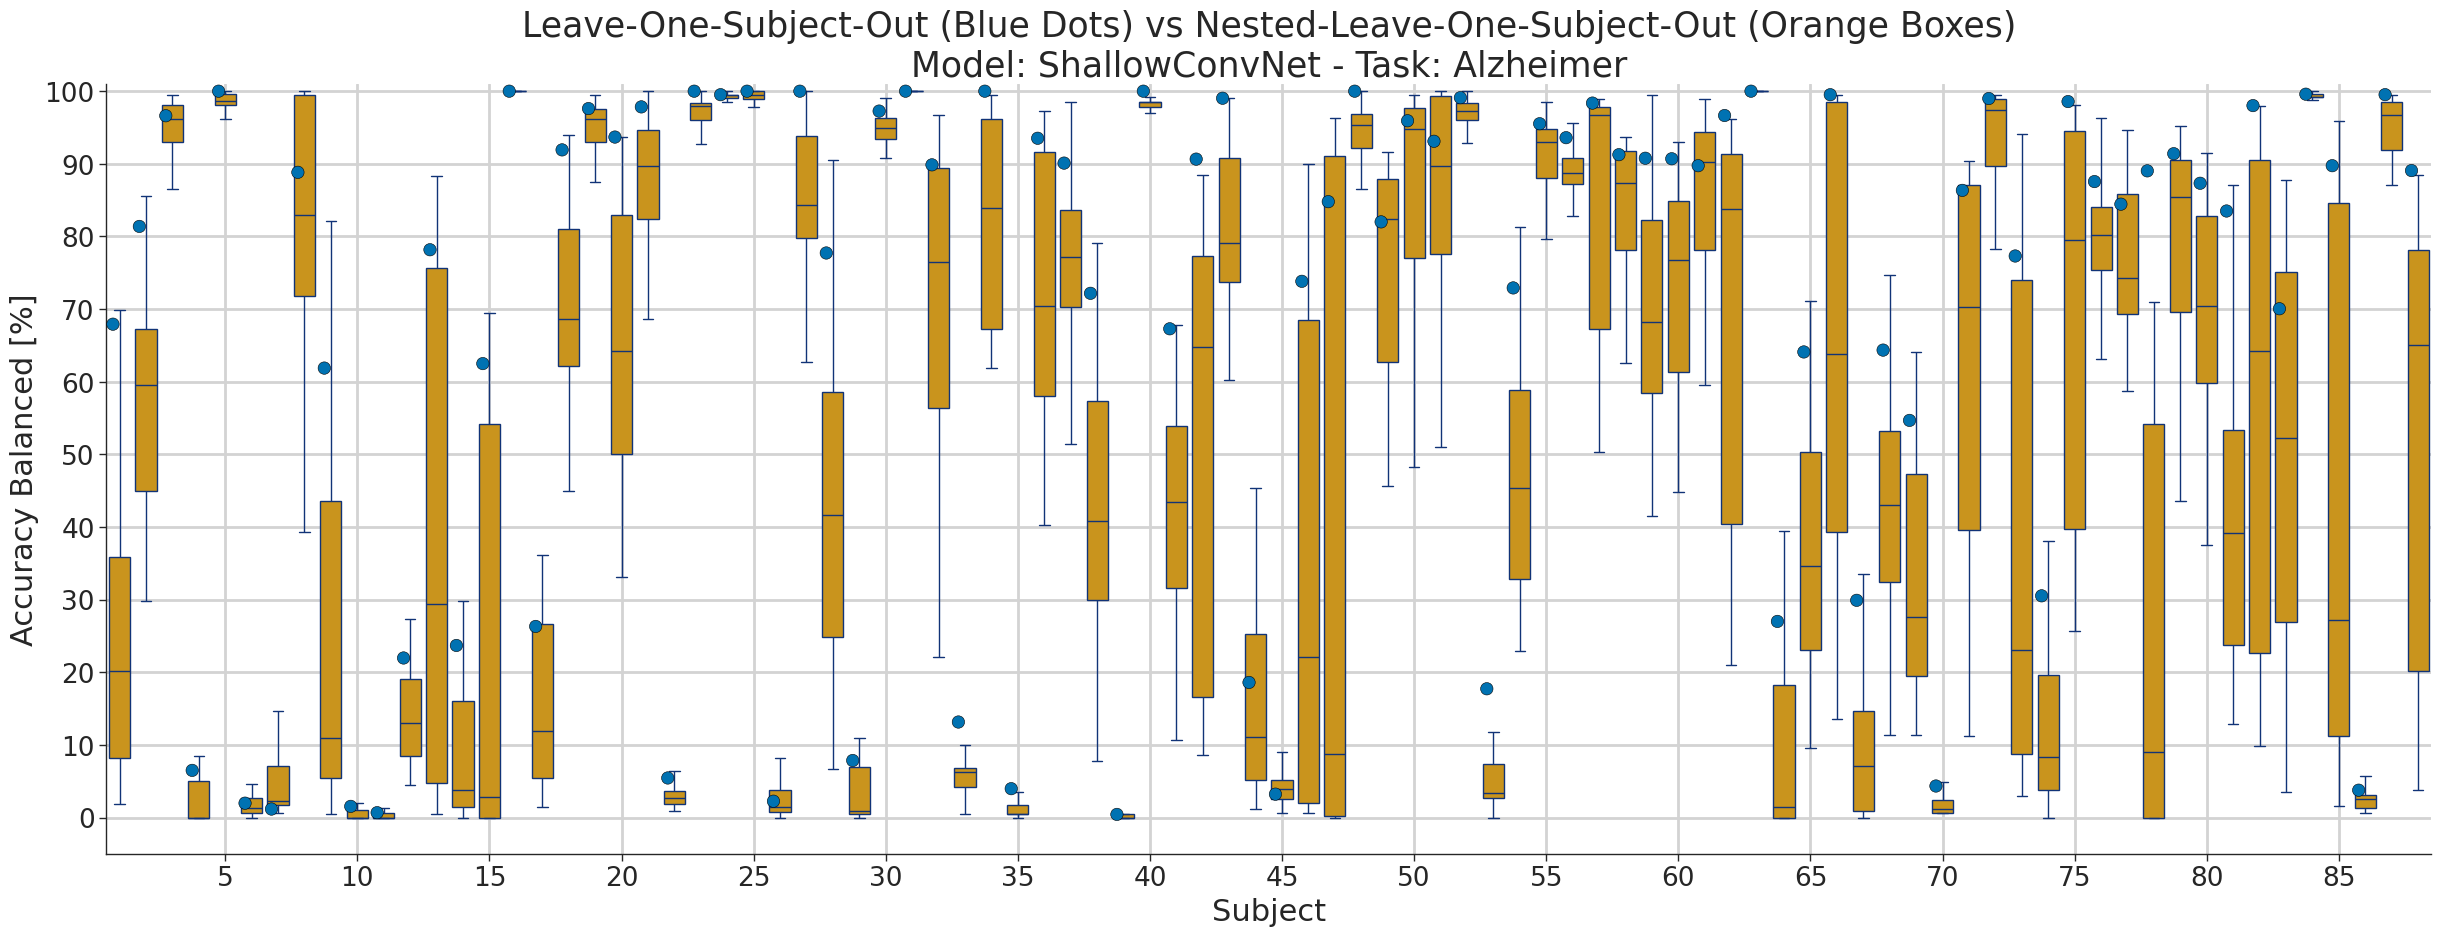

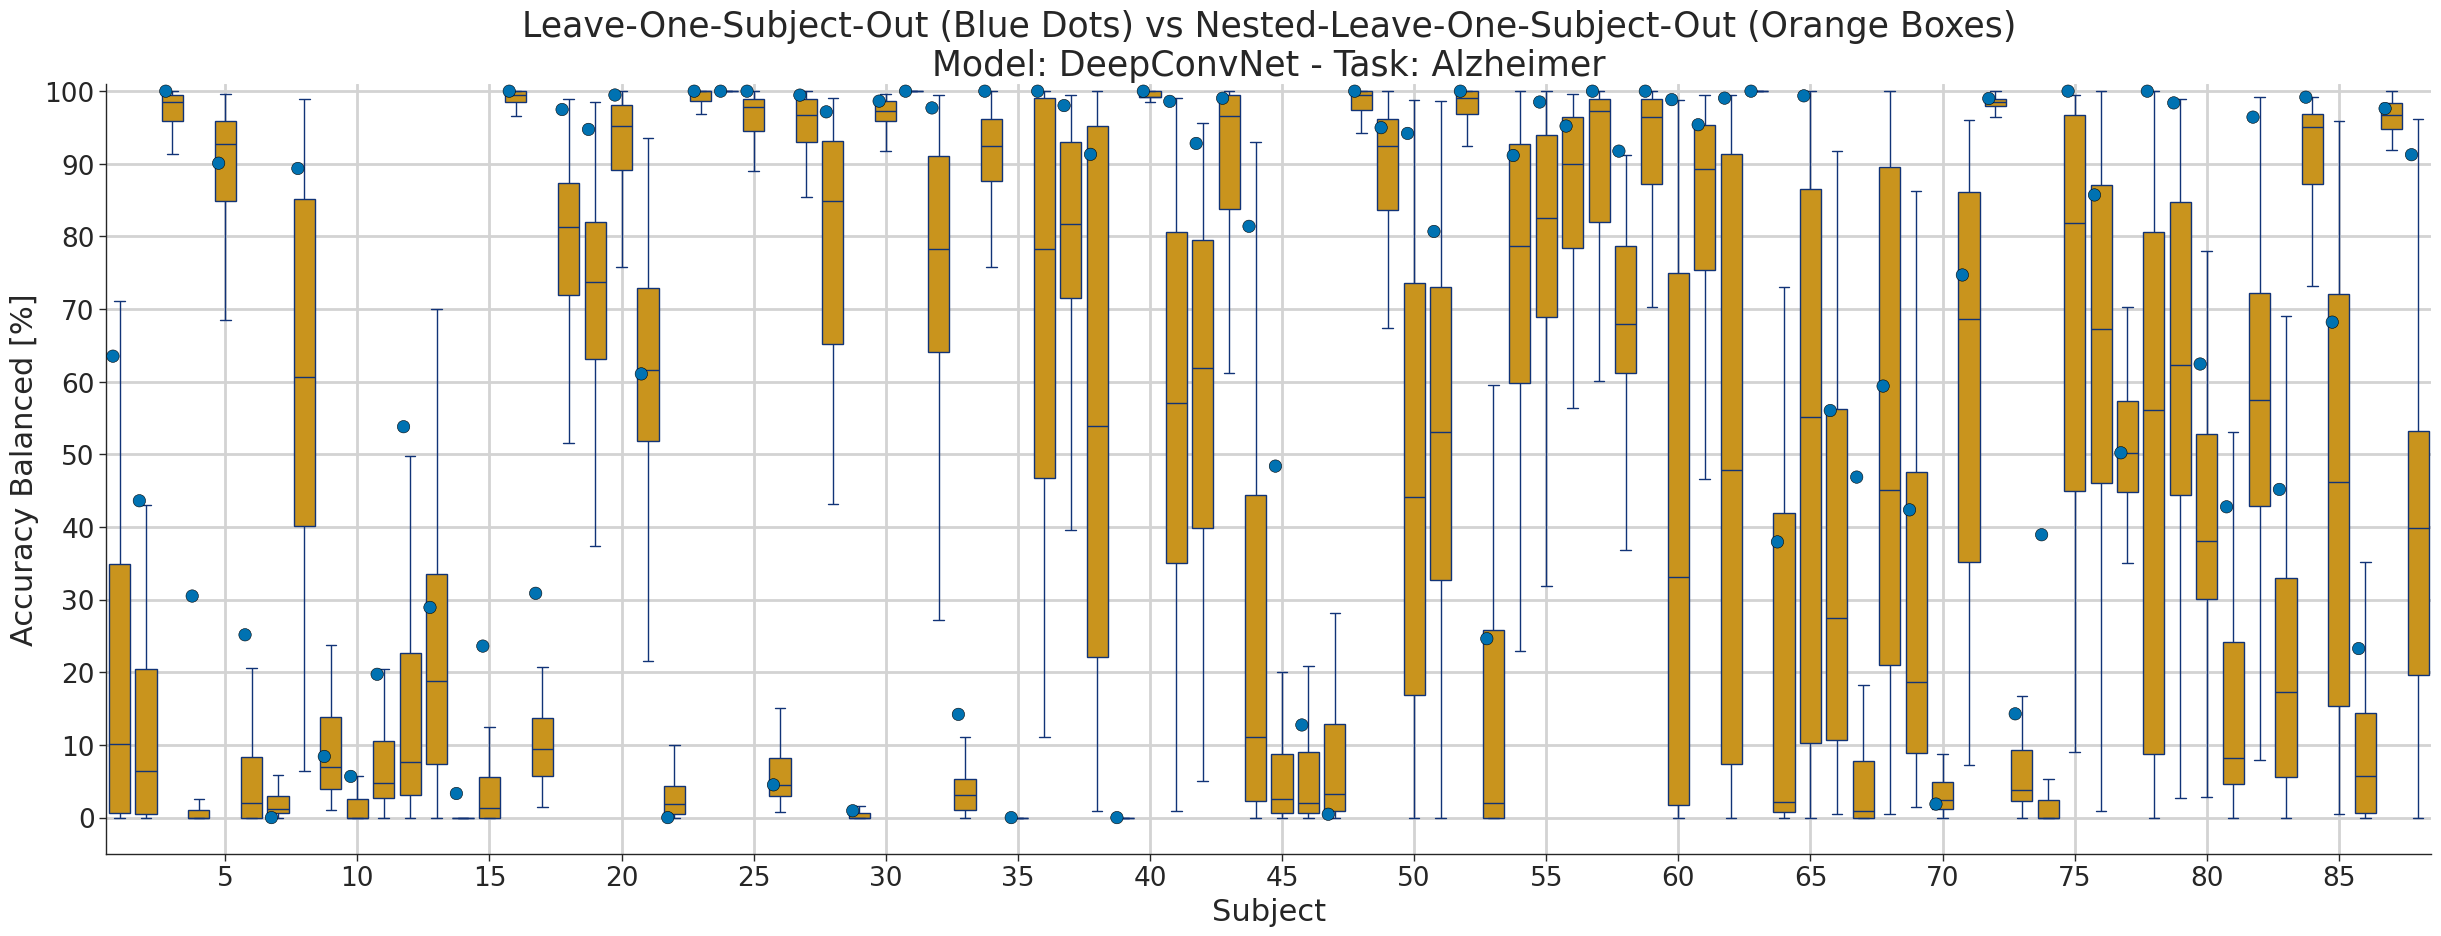

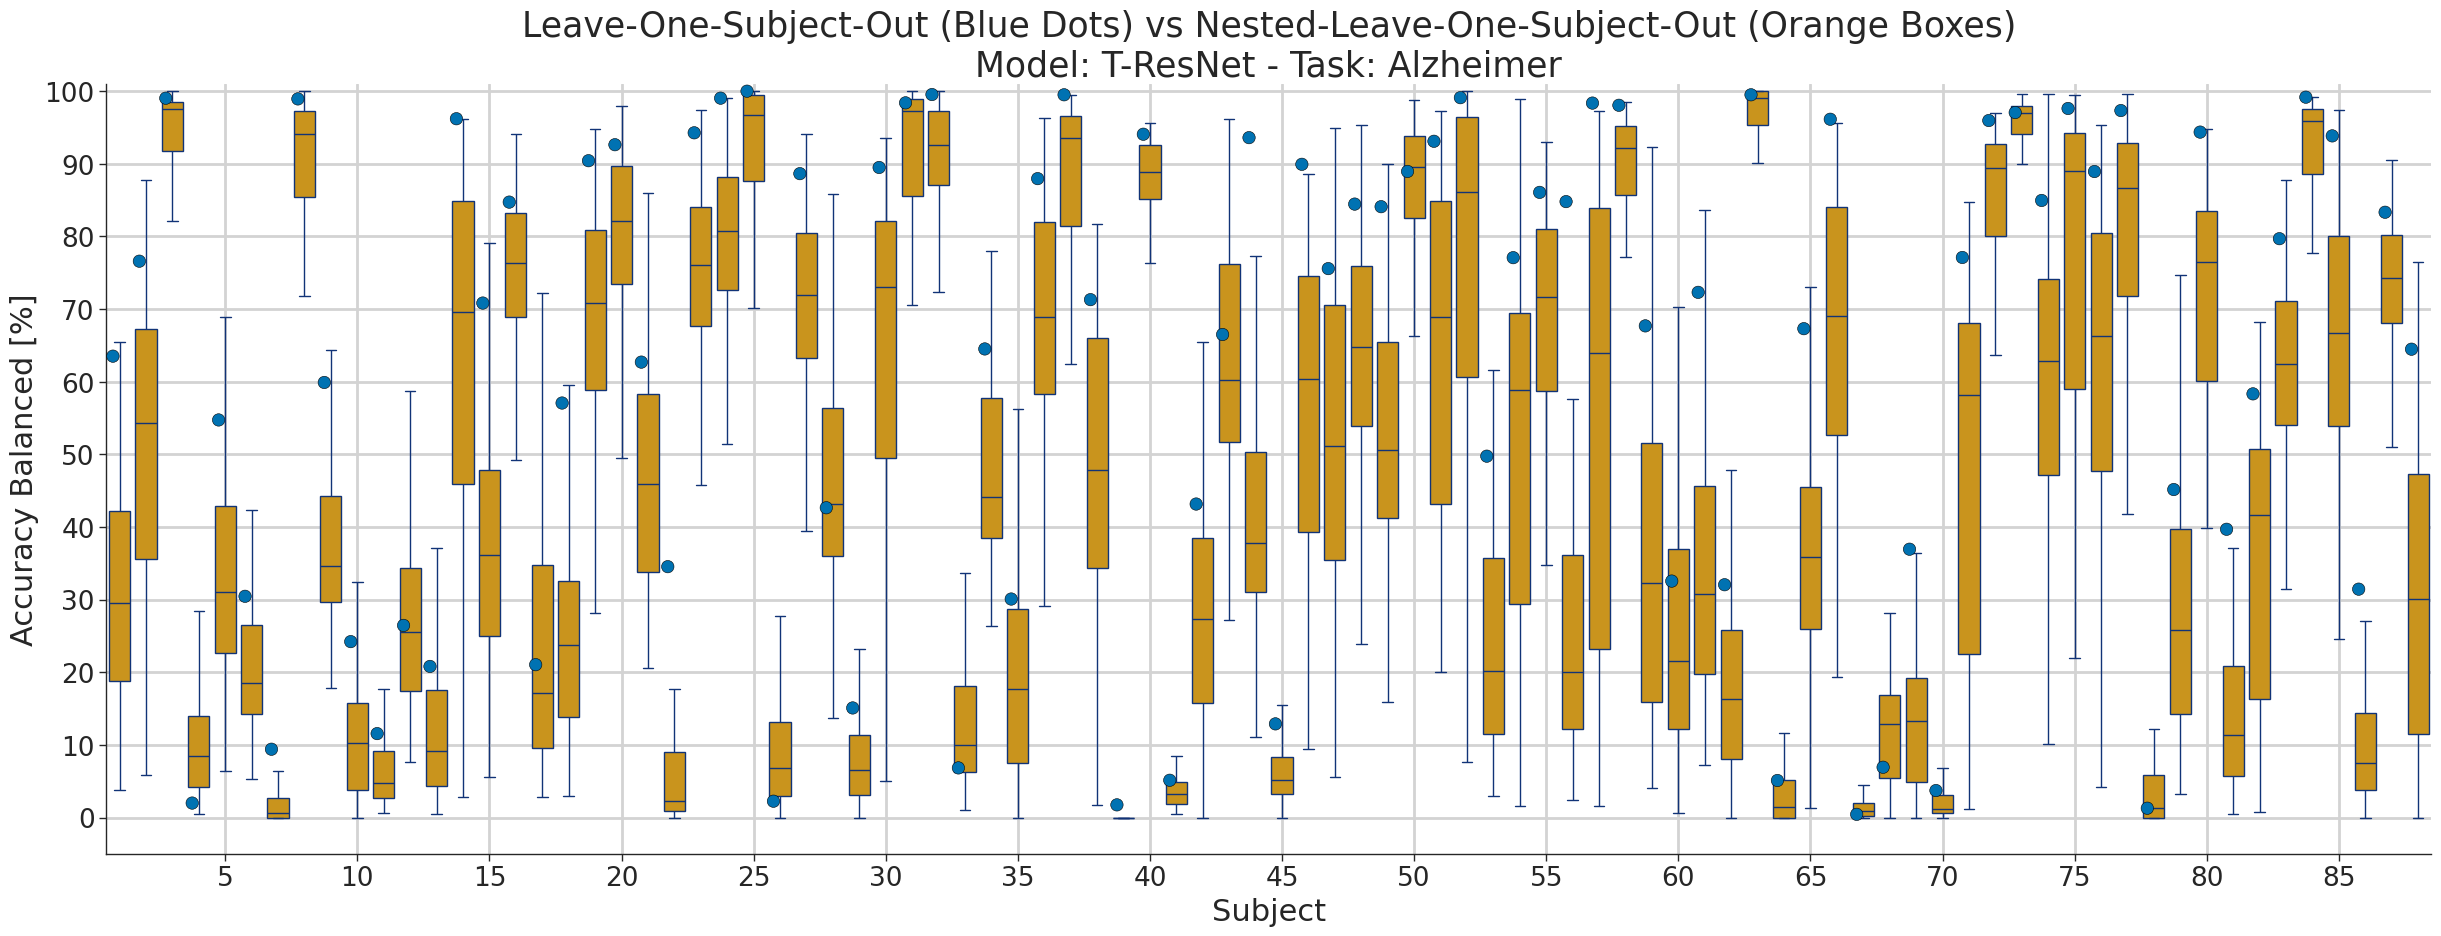

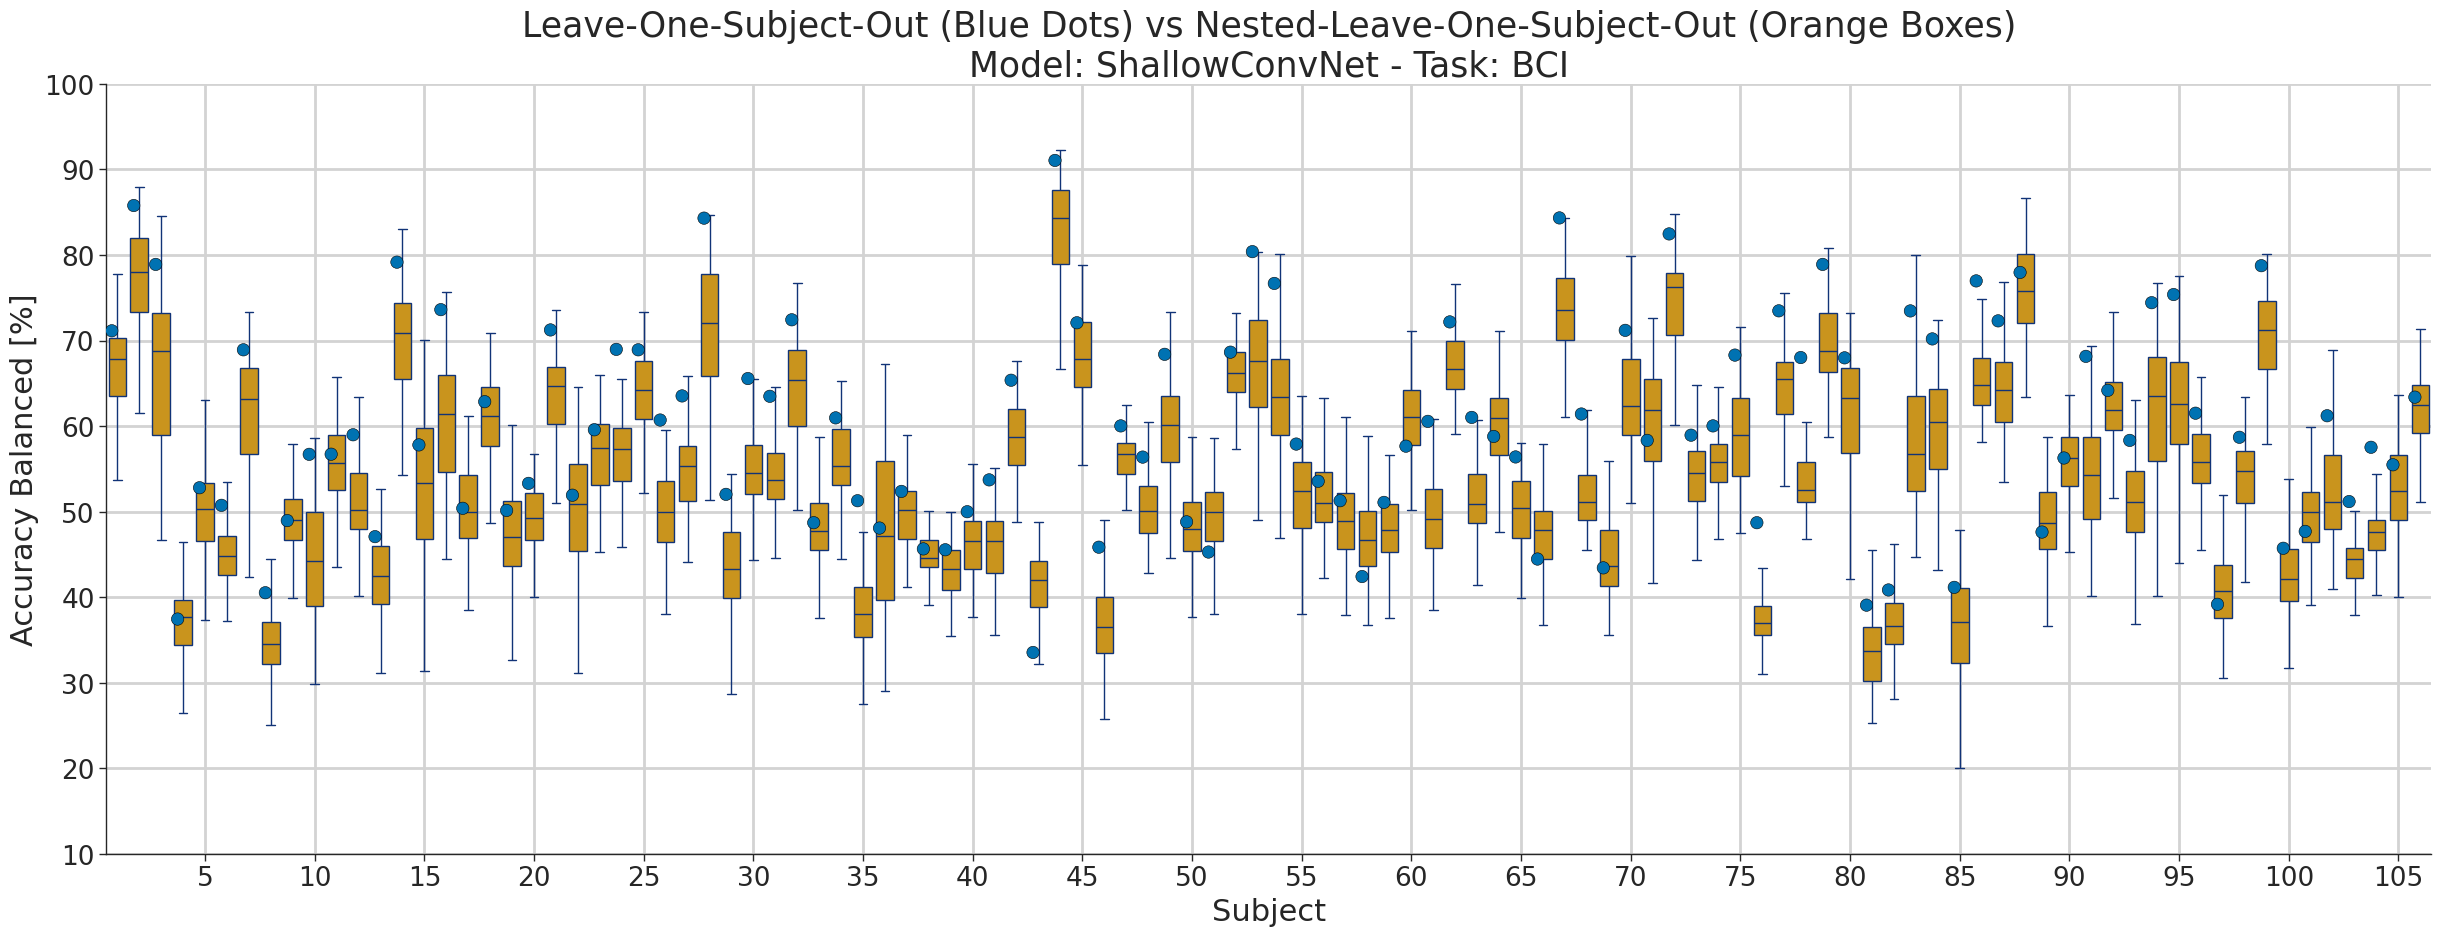

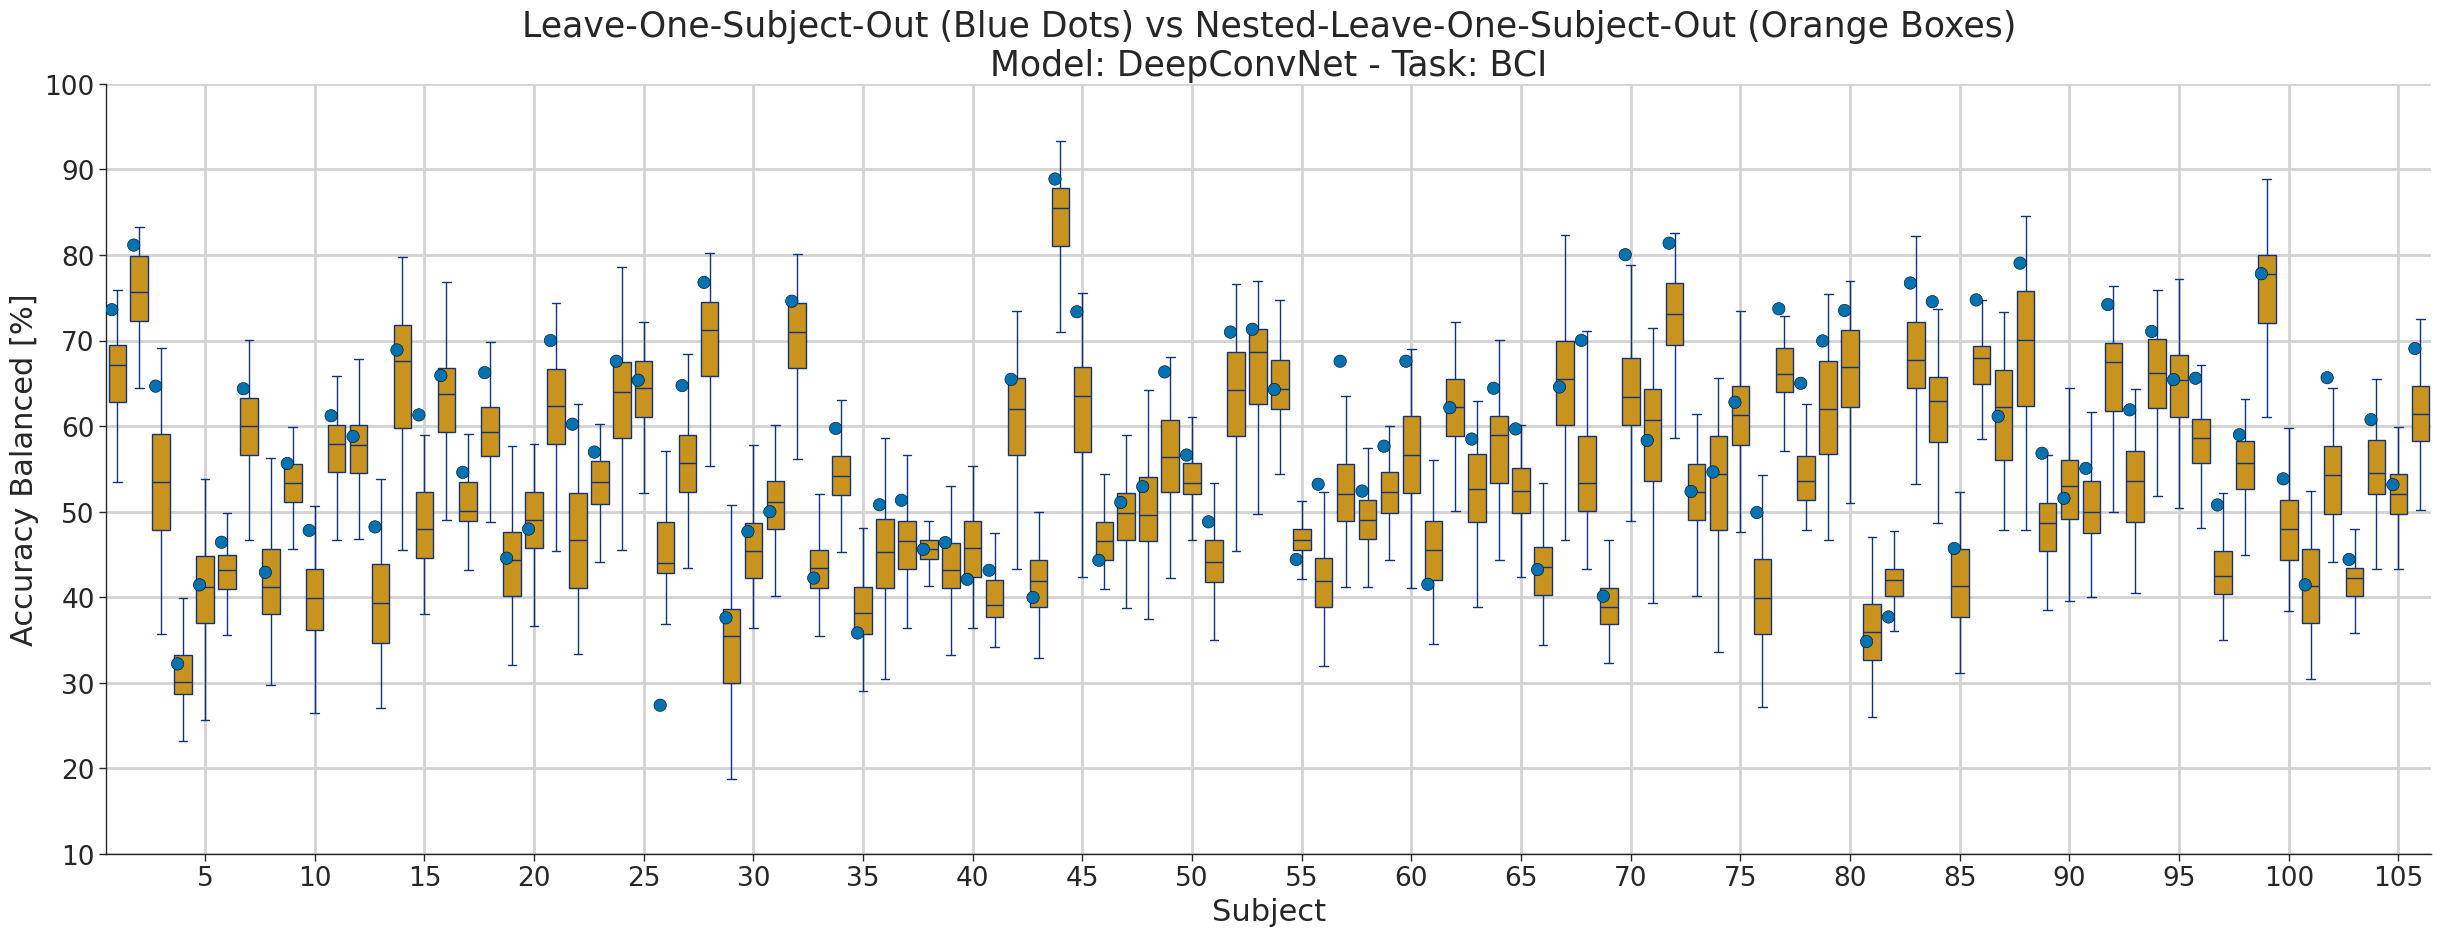

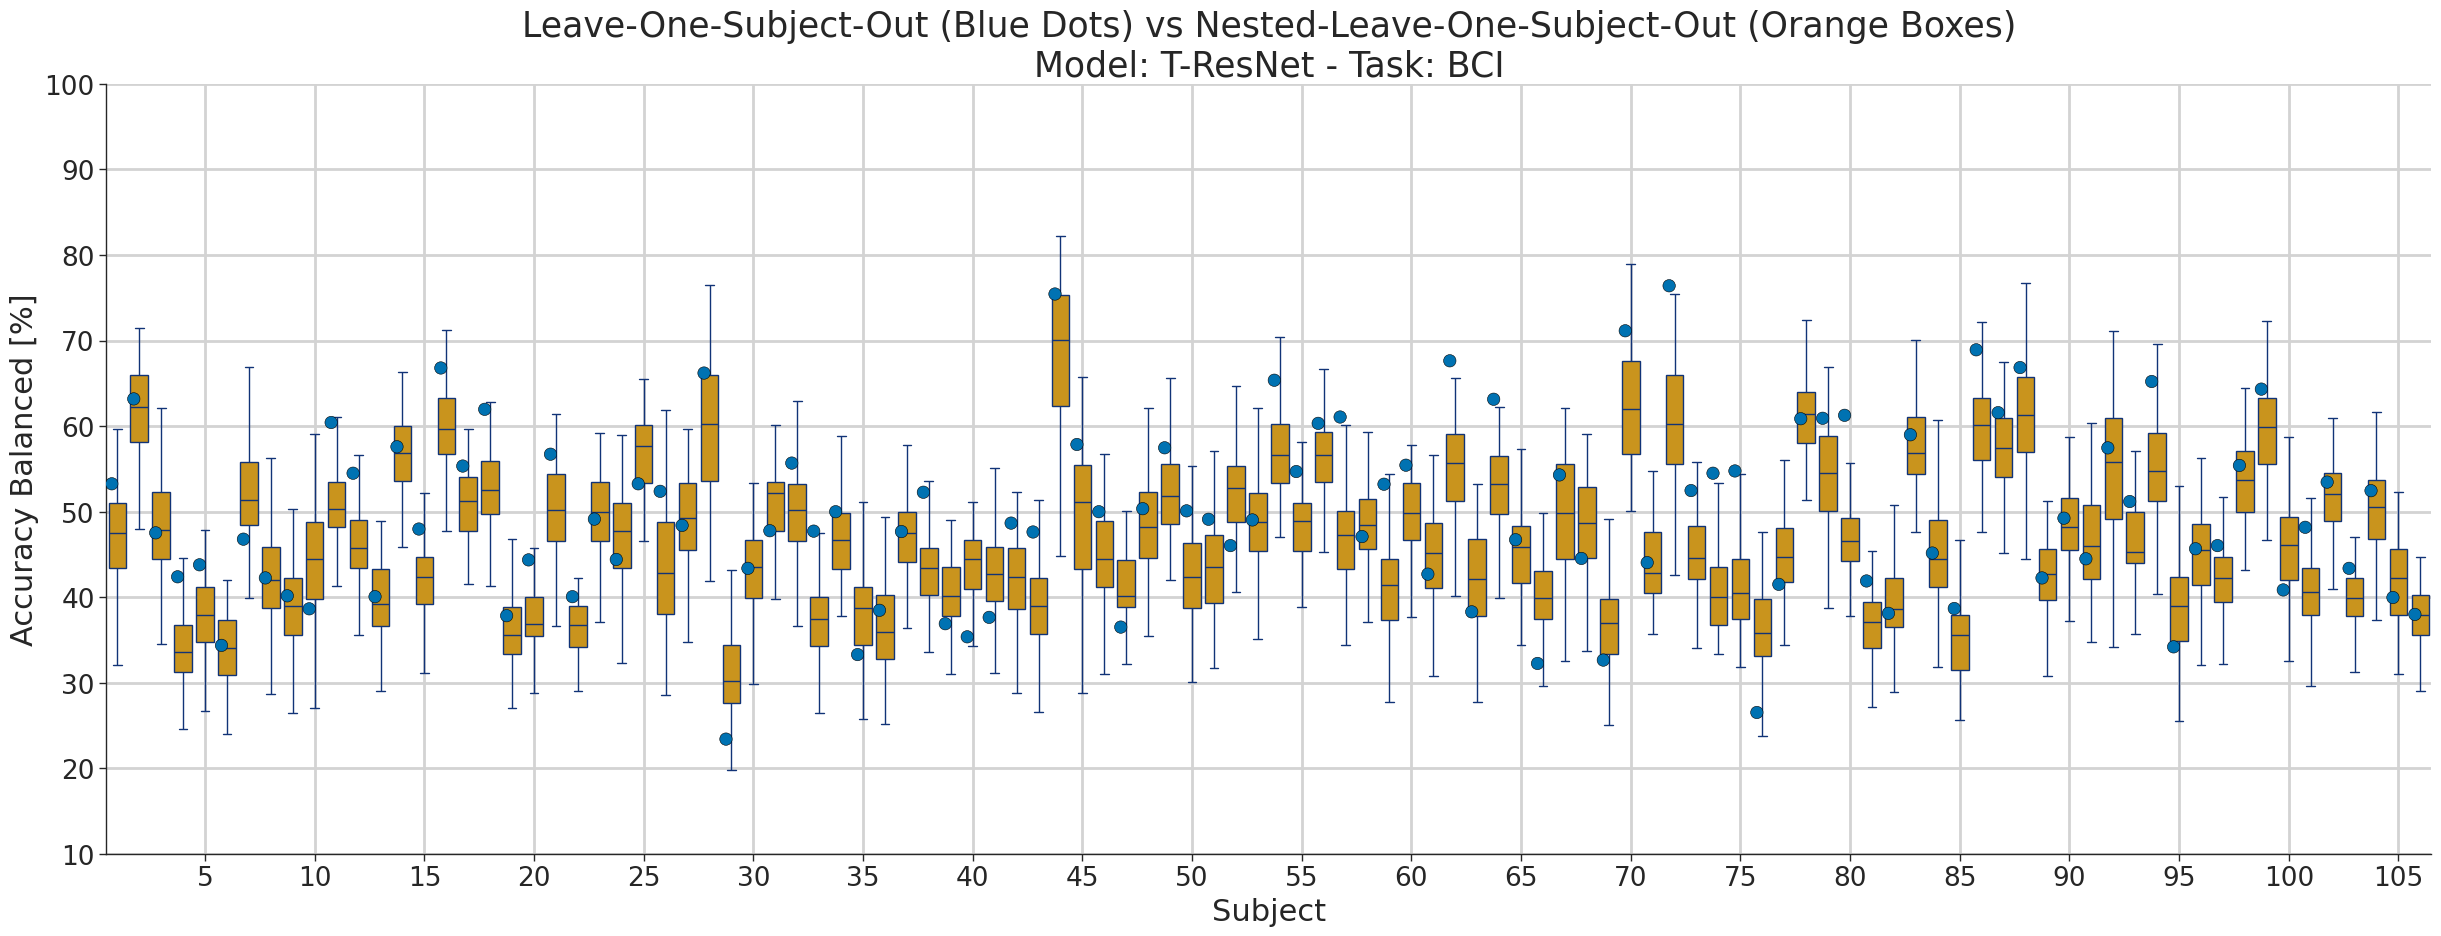

In [5]:
Nsubj_dict = {'alz': 88,'pds': 81,'bci': 106}
font=250
boxcolor     = "#56b4e9"#'#d55e00'
fliercolor   = 'gray'
linecolor    = '#137'
scattercolor = "#c97b63"#009292' 

scattercolor = "#0072b2"#'#009292' 
boxcolor     = '#e69f00'
for k in task:
    Nsubj = Nsubj_dict[k]
    for i in model:
        loso = performances_df.loc[(
            (performances_df['Task']==k) &
            (performances_df['Model']==i) & 
            (performances_df['Partition']=="LOSO")
        ), "Metric"].values
        nloso_pd = performances_df.loc[(
            (performances_df['Task']==k) &
            (performances_df['Model']==i) & 
            (performances_df['Partition']=="NLOSO")
        )]
        nloso = nloso_pd["Metric"].values
        nloso = nloso.reshape(Nsubj,Nsubj-1)
        nloso_med = np.median(nloso,1)
        nloso_min = np.min(nloso,1)
        nloso_max = np.max(nloso,1)
        nloso_err = np.stack((nloso_med-nloso_min, nloso_max-nloso_med),1).T
        font = 22
        range_x = np.arange(Nsubj)
        fig, ax = plt.subplots(figsize=(30, 10))
        sns.scatterplot(x=range_x-0.25, y=loso, ax=ax, hue=np.zeros(Nsubj),
                        legend=False, edgecolor = 'black', zorder=10,
                        palette=[scattercolor]) # #'009e73' '#D55E00' #881a58
        ax.collections[0].set_sizes([80])
        sns.boxplot(data=nloso_pd, x="Outer", y="Metric", ax=ax, fill=True, showfliers=False,
                    linecolor=linecolor,
                    flierprops=dict(marker='o', markerfacecolor=fliercolor, linestyle='none', markeredgecolor=fliercolor),
                    palette=[boxcolor]*Nsubj) #56b4e9
        #sns.stripplot(data=nloso_pd, x="Outer", y="Metric", ax=ax, legend=False, palette=['#a53606']*Nsubj)
        ax.set_yticks([i*10 for i in range(0, 11)])
        ax.set_xticks([5-1] + [i*5-1 for i in range(2, (Nsubj)//5 +1)])
        ax.tick_params(axis='both', which='major', labelsize=font-3)
        ax.set_title(
            f'Leave-One-Subject-Out (Blue Dots) vs Nested-Leave-One-Subject-Out (Orange Boxes)\nModel: {get_full_name(i)} - Task: {get_full_name(k)}',
            fontsize = font+3
        )
        ax.set_xlabel('Subject', fontsize = font)
        ax.set_ylabel('Accuracy Balanced [%]', fontsize = font)
        if k == 'bci':
            ax.set_ylim(10, 100)
        else:
            ax.set_ylim(-5,101)
        ax.xaxis.grid(True, linewidth=2)
        ax.yaxis.grid(True, linewidth=2)
        plt.savefig(f"Images/{folder}/LOSO_vs_FNLOSO_model_{get_full_name(i)}_tasks_{get_full_name(k)}.pdf")
        plt.show()

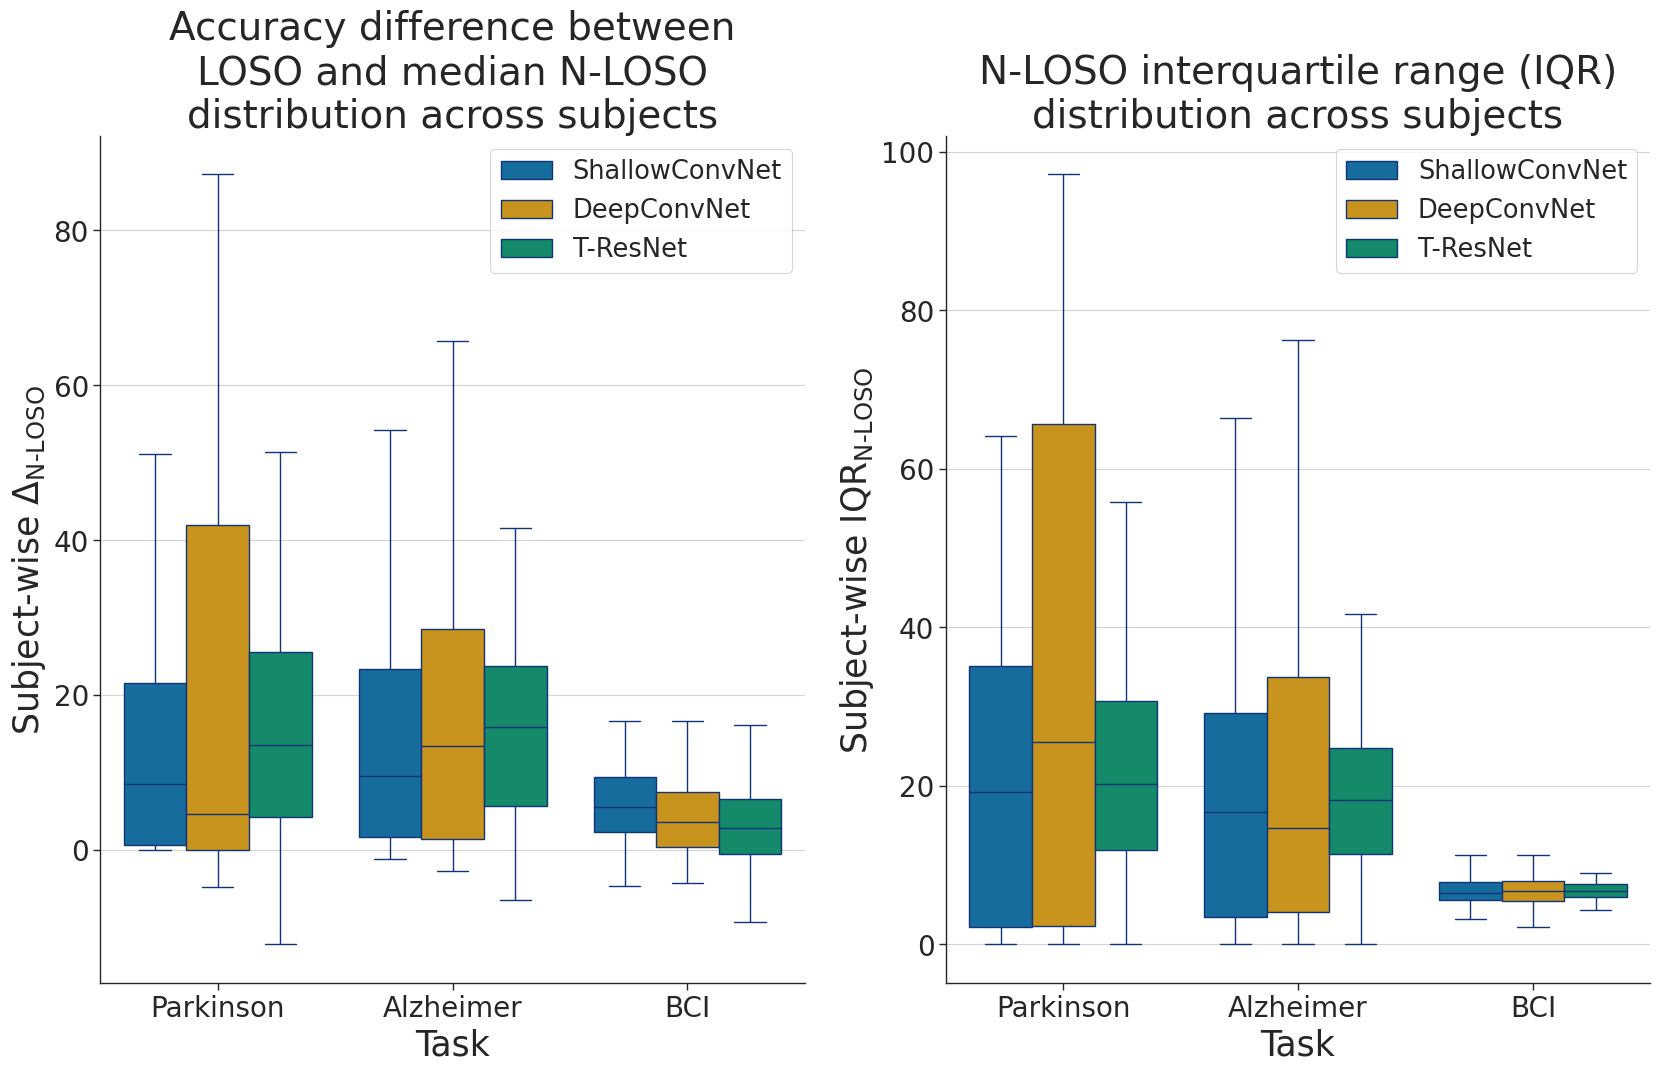

In [6]:
Nsubj_dict = {'pds': 81, 'alz': 88, 'bci': 106}
font=25
metric_diff = [np.zeros((3, Nsubj)) for Nsubj in Nsubj_dict.values()]
metric_var = [np.zeros((3, Nsubj)) for Nsubj in Nsubj_dict.values()]


for n, k in enumerate(task):
    Nsubj = Nsubj_dict[k]
    for m, i in enumerate(model):
        loso = performances_df.loc[(
            (performances_df['Task']==k) &
            (performances_df['Model']==i) & 
            (performances_df['Partition']=="LOSO")
        ), "Metric"].values
        nloso_pd = performances_df.loc[(
            (performances_df['Task']==k) &
            (performances_df['Model']==i) & 
            (performances_df['Partition']=="NLOSO")
        )]
        nloso = nloso_pd["Metric"].values
        nloso = nloso.reshape(Nsubj,Nsubj-1)
        nloso_med = np.median(nloso,1)
        nloso_var = np.subtract(*np.percentile(nloso,[75, 25], axis=1))

        #nloso_med = np.mean(nloso,1)
        #nloso_var = np.std(nloso,1)
        
        metric_diff[n][m] = loso-nloso_med
        metric_var[n][m] = nloso_var
    
    nloso = pd.DataFrame(metric_diff[n].T, columns=[get_full_name(l) for l in model])
    nloso['Task'] = get_full_name(k)
    nloso_var = pd.DataFrame(metric_var[n].T, columns=[get_full_name(l) for l in model])
    nloso_var['Task'] = get_full_name(k)
    if n==0:
        nloso_tot = nloso
        nloso_var_tot = nloso_var
    else:
        nloso_tot = pd.concat([nloso_tot, nloso])
        nloso_var_tot = pd.concat([nloso_var_tot, nloso_var])

nloso_tot = pd.melt(
    nloso_tot,
    id_vars=['Task'],
    value_vars=['ShallowConvNet', 'DeepConvNet', 'T-ResNet'],
    var_name='Model',
    value_name='Metric'
)

nloso_var_tot = pd.melt(
    nloso_var_tot,
    id_vars=['Task'],
    value_vars=['ShallowConvNet', 'DeepConvNet', 'T-ResNet'],
    var_name='Model',
    value_name='Metric'
)

fig, ax = plt.subplots(1, 2, figsize=(20, 11))
sns.boxplot(
    data      = nloso_tot,
    x         = 'Task',
    y         = 'Metric',
    legend    = True,
    linewidth = 1,
    hue       = 'Model',
    ax        = ax[0],
    showfliers= False,
    linecolor = '#137',
    palette   = ["#0072b2", "#e69f00", "#009e73"]
)
ax[0].legend(fontsize = font-6.5, loc = "upper right")
ax[0].tick_params(axis='both', which='major', labelsize=font-5)
ax[0].set_xlabel('Task', fontsize = font)
ax[0].set_ylabel(r'Subject-wise $\Delta_{\text{N-LOSO}}$', fontsize = font)
ax[0].set_title(f'Accuracy difference between\nLOSO and median N-LOSO\ndistribution across subjects', fontsize = font+3)

sns.boxplot(
    data      = nloso_var_tot,
    x         = 'Task',
    y         = 'Metric',
    legend    = True,
    linewidth = 1,
    hue       = 'Model',
    ax        = ax[1],
    showfliers= False,
    linecolor = '#137',
    palette   = ["#0072b2", "#e69f00", "#009e73"]
)
ax[1].legend(fontsize = font-6.5, loc = "upper right")
ax[1].tick_params(axis='both', which='major', labelsize=font-5)
ax[1].set_xlabel('Task', fontsize = font)
ax[1].set_ylabel(r'Subject-wise $\text{IQR}_{\text{N-LOSO}}$', fontsize = font)
ax[1].set_title(f'N-LOSO interquartile range (IQR)\ndistribution across subjects', fontsize = font+3)
plt.savefig(f"Images/{folder}/LOSO_vs_FNLOSO_model_delta_and_iqr.pdf")
plt.show()